<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230702_DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift tolerant machine learning method

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [4]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

In [5]:
main_figsize=(15,3)

In [6]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):

    def __init__(self,input_dim):
        """Initializes DiscriminatorF with torch components."""

        super(Sensitivity_Adapter, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        #self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(2, self.input_dim*10))
            #self.fc2.append(nn.BatchNorm1d(num_features=50))
            self.fc3.append(nn.Linear(self.input_dim*10, 1))

        #self.fc = nn.Linear(input_dim, input_dim)

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = F.relu(self.fc2[i](h0))
            #h2 = self.fc3[i](h1)
            h2 = self.fc3[i](F.relu(h0))
            pxy.append(h2)

        #return self.fc(torch.tensor(torch.cat(pxy, dim=1), requires_grad = True))
        return torch.cat(pxy, dim=1)


In [115]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).

    This class is for defining the structure of FR-Train generator (classifier).
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """

    def __init__(self, input_dim=5):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.

        Args:
            input_data: The input data.

        Returns:
            The predicted label (y_hat) for the given input data.
        """

        output = self.model(input_data)
        return output


In [121]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score

def test_model(model_,model2_, tX, ty, avaible_range,columns):
    model_.eval()

    b_dim = tX.shape[1]-1

    if model2_ == None:
        ax = tX[:,0:b_dim]
    else:
        model2_.eval()
        ax = model2_(tX[:,0:b_dim],tX[:,b_dim].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    print('ty',ty.shape)
    print('y_hat',y_hat.shape)
    ty_ = ty.cpu().data.numpy()
    f1 = f1_score(ty_,y_hat)
    #################### MI #########################
    ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
    haf_size = int(ax_df.shape[0]/2)

    mi_scores = make_mi_scores(ax_df, y_hat, discrete_features="auto")
    sum_mi = np.sum(mi_scores)
    std_mi = np.std(mi_scores)

    mi_scores = make_mi_scores(ax_df[0:haf_size], y_hat[0:haf_size], discrete_features="auto")
    asum_mi = np.sum(mi_scores)
    astd_mi = np.std(mi_scores)

    mi_scores = make_mi_scores(ax_df[-haf_size:], y_hat[-haf_size:], discrete_features="auto")
    bsum_mi = np.sum(mi_scores)
    bstd_mi = np.std(mi_scores)

    print("Test f1 score: {}".format(f1))
    '''
    print("Sum of MI = {:.5f}".format(sum_mi))
    print("Std of MI = {:.5f}".format(std_mi))
    print("Sum of MI A = {:.5f}".format(asum_mi))
    print("Std of MI A = {:.5f}".format(astd_mi))
    print("Sum of MI B = {:.5f}".format(bsum_mi))
    print("Std of MI B = {:.5f}".format(bstd_mi))
    print("ABS(sum(A-B)) = {:.5f}".format(np.abs(asum_mi-bsum_mi)))
    print("ABS(std(A-B)) = {:.5f}".format(np.abs(astd_mi-bstd_mi)))
    '''
    return f1, (sum_mi,std_mi,asum_mi,astd_mi,bsum_mi,bstd_mi,np.abs(asum_mi-bsum_mi),np.abs(astd_mi-bstd_mi))

In [129]:

def test_all_data(generator,adapter,X_train, X_live, Y_live, train_size, test_size, avaible_range, columns, ShowChart = False,bucket_size_array=[200]):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('X_live.shape',X_live.shape)
    b_dim = X_live.shape[1]-1
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set),dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []
    MISS = {}
    DRF = {}
    for col in columns:
        MISS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        if adapter == None:
            xs = X_live_unit[:,0:b_dim]
        else:
            xs = adapter(X_live_unit[:,0:b_dim],X_live_unit[:,b_dim].reshape(-1,1)/avaible_range)
        predicted_y = generator(xs)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        f1s.append(f1_)

        cpu_xs = xs.cpu().data.numpy()
        mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,cpu_xs)
        for ix,col in enumerate(columns):
            MISS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MISS)
    df_drf = pd.DataFrame(DRF)

    if ShowChart:
        plt.figure(figsize=main_figsize)
        plt.plot(f1s,linewidth=1)
        plt.ylabel('F1 Score')
        plt.xlabel(f'bucket ({train_size})')
        plt.show()

        df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({train_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

        df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({train_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

    print(f'mean of drift:\n{df_drf.mean()}')
    print('Mean F1 for all data:',np.mean(f1s))

    return f1s, df_mis, df_drf

In [10]:
H=20

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        #self.fc4 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y.reshape(-1,1)))
            h1 = self.fc3[i](h0)
            h.append(h1)

        return torch.cat(h, dim=1)

class customLoss(nn.Module):
    def __init__(self, model):
        super(customLoss, self).__init__()
        self.model = model

    def forward(self, x,y):
        minibatch = int(x.shape[0] * 0.8)
        s = np.random.choice(x.shape[0],minibatch)
        #x_sample = Variable(torch.from_numpy(x[s,:]).type(torch.FloatTensor), requires_grad = True)
        #y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        #y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)
        x_sample = x[s,:] #Variable(x[s,:], requires_grad = True)
        y_sample = y[s] #Variable(, requires_grad = True)
        y_shuffle = y[torch.randperm(minibatch)] #Variable(, requires_grad = True)
        p_xy = self.model(x_sample, y_sample)
        p_x_y = self.model(x_sample, y_shuffle)
        ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
        loss = - ret
        return loss

In [122]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, avaible_range, alpha, columns,ShowChart = False, do_mine=True):
    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    #s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch

    b_dim = XS_train.shape[1]-1

    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss(reduce=False)  # mean square error

    # Initializes generator and discriminator
    generator = Generator(b_dim).to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]


    adapter = Sensitivity_Adapter(b_dim).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net(b_dim).to(device)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.01)
    loss_mse = customLoss(mine)



    for epoch in tqdm(range(n_epochs)):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------

        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range) # z0, b
            ml = torch.mean(mse_loss(xs, XS_train[:,0:b_dim]),dim=0)
            a_loss =  torch.sum(ml) + torch.std(ml)
        else:
            xs = XS_train[:,0:b_dim]
            a_loss = torch.tensor(0.0)

        a_losses.append(a_loss.cpu().data.numpy())
        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)

        if do_mine and lambda_f >= 0.0:
            # -------------------
            #  Forwards MINE
            # -------------------
            mine_loss = loss_mse(xs,y_train)
        else:
            mine_loss = torch.tensor(0.0)

        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) + mine_loss.mean()
        g_losses.append(g_loss.cpu().data.numpy())




        optimizer_A.zero_grad()
        optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        if lambda_f >= 0.0:
            loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha #* 0.05
        else:
            loss = g_loss

        loss.backward()
        optimizer_G.step()
        optimizer_M.step()
        optimizer_A.step()
        '''
        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )
        '''
        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,mi = test_model(generator,adapter, XS_test, y_test, avaible_range,columns)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Adapter loss':a_losses,'Classifier loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({XS_train.shape[0]})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    plt.figure(figsize=main_figsize)
    plt.plot(a_losses,linewidth=1,label='Adapter loss')
    plt.plot(g_losses,linewidth=1,label='classifier loss')
    plt.ylabel('loss')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=2)
    plt.show()
    '''
    return f1,mi,generator,adapter,df_loss

In [12]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [13]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [14]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

def check_mi_drift(X:pd.DataFrame,Y:np.array,train_size:int,test_size:int):

    mi_scores = make_mi_scores(X, Y, discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    columns = X.columns
    scaler_c1 = MinMaxScaler()
    # trainset을 가지고 Scaler를 fit하고, testset을 포함한 그 이후의 Data를 모두 transform 한다.
    X = pd.DataFrame(np.concatenate((scaler_c1.fit_transform(X[0:train_size]), scaler_c1.transform(X[train_size:])),axis=0), columns=columns)

    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = np.asarray(X_live_set)
    Y_live_set = np.asarray(Y_live_set)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = pd.DataFrame(X_live_unit,columns = columns)
        mi_scores = make_mi_scores(X_live_unit, Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,X_live_unit.values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis.values,linewidth=1,label=columns)
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({train_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf.values,linewidth=1,label=columns)
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({train_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    return X,Y

In [15]:
import copy
import torch.optim as optim

def train_classificaion_model(X,Y,train_size, test_size):
    seed_everything()

    mi_scores = make_mi_scores(X[test_size:test_size+train_size], Y[test_size:test_size+train_size], discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # Convert to 2D PyTorch tensors
    X_train = torch.tensor(X[:train_size].values, dtype=torch.float32).to(device)
    y_train = torch.tensor(Y[:train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    X_test = torch.tensor(X[test_size:test_size+train_size].values, dtype=torch.float32).to(device)
    y_test = torch.tensor(Y[test_size:test_size+train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    in_dim = X_train.shape[1]
    # Define the model
    model = nn.Sequential(
        nn.Linear(in_dim, in_dim*4),
        nn.ReLU(),
        nn.Linear(in_dim*4, in_dim),
        nn.ReLU(),
        nn.Linear(in_dim, 1),
        nn.Sigmoid()
    ).to(device)

    # loss function and optimizer
    loss_fn = nn.BCELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 1000   # number of epochs to run
    batch_size = 100  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))
    plt.plot(history)
    plt.show()

    from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
    predicted_y = model(X_test)
    f1_ = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
    print(f'F1 Score:{f1_:.5f}')

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set), dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []

    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        predicted_y = model(X_live_unit)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        f1s.append(f1_)

    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({train_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

    result_table3 = {}
    #result_table3['lambda']=[]
    result_table3['test_f1']=[]
    result_table3['init_f1']=[]
    result_table3['mean_f1']=[]
    result_table3['last_f1']=[]
    result_table3['SUM(MI)']=[]

    #result_table3['lambda'].append('Case #1 Feature 5')
    result_table3['test_f1'].append(f1_)
    result_table3['init_f1'].append(f1s[0])
    result_table3['mean_f1'].append(np.mean(f1s))
    result_table3['last_f1'].append(f1s[-1])
    result_table3['SUM(MI)'].append(np.sum(mi_scores))

    result = pd.DataFrame(result_table3)
    print(result)
    return model, result

In [126]:
def drift_tolerant(X, Y,train_size, test_size,avaible_range = 400,lambda_f2 = 1.0):

    columns = X.columns[:-1]
    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    train_tensors = Namespace(XS_train = torch.tensor(X_train.values, dtype=torch.float32),
                            y_train = torch.tensor(Y_train, dtype=torch.float32))
    test_tensors = Namespace(XS_test = torch.tensor(X_test.values, dtype=torch.float32),
                            y_test = torch.tensor(Y_test, dtype=torch.float32))

    train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
    lambda_f_set = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] #[-0.1,0.0,0.5] #
    lambda_a2 = 0.0

    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    result_table2['sum mi']=[]
    result_table2['std mi']=[]
    result_table2['sum * std']=[]
    result_table2['sum 1/2']=[]
    result_table2['std 1/2']=[]
    result_table2['sum 2/2']=[]
    result_table2['std 2/2']=[]
    result_table2['sum 1-2']=[]
    result_table2['std 1-2']=[]
    result_table2['sum 1+2']=[]
    result_table2['std 1+2']=[]
    infos = {}
    for lambda_f in lambda_f_set:
        print(f'######################### Lambda {lambda_f} ###########################')
        f1,mi,last_generator, last_adapter, df_loss = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, avaible_range = avaible_range, alpha= lambda_f2,columns = columns)# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_generator,last_adapter,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #1, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        result_table2['sum mi'].append(mi[0])
        result_table2['std mi'].append(mi[1])
        result_table2['sum * std'].append(mi[0]*mi[1])
        result_table2['sum 1/2'].append(mi[2])
        result_table2['std 1/2'].append(mi[3])
        result_table2['sum 2/2'].append(mi[4])
        result_table2['std 2/2'].append(mi[5])
        result_table2['sum 1-2'].append(mi[6])
        result_table2['std 1-2'].append(mi[7])
        result_table2['sum 1+2'].append(mi[2]+mi[4])
        result_table2['std 1+2'].append(mi[3]+mi[5])

    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df[1:]['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    best_lambda = result4_df[result4_df['sum * std']== np.min(result4_df[1:]['sum * std'])]['lambda']
    result_df[['Normal model',f'λ_{best_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    return result4_df

# 실험
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

### Dataset 준비

In [131]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [132]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

In [133]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

### 실험

MI Analysis MI Max 0.20278, Min 0.02707, Mean 0.09885, Std 0.06305
Dataset structure X_train, (1800, 5) X_test, (1800, 5) X_live (39800, 5)
Truncate 7200 rows from live_set (39800, 5)
Search MI & Drift...for X_live_set (191, 1800, 5)


100%|██████████| 191/191 [00:07<00:00, 25.31it/s]


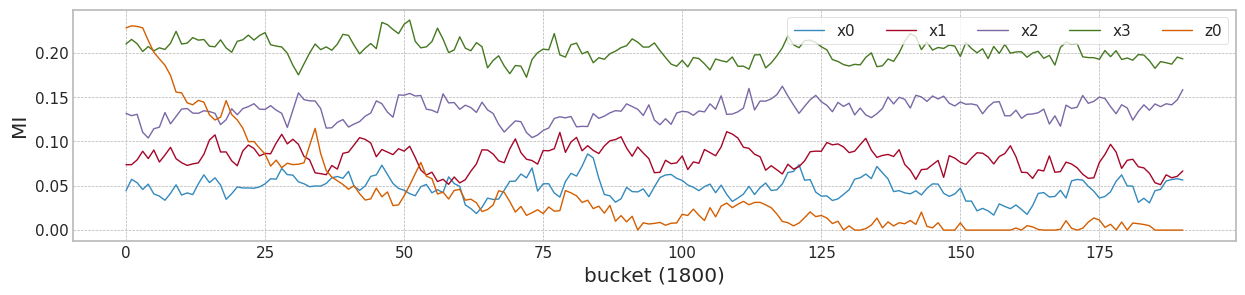

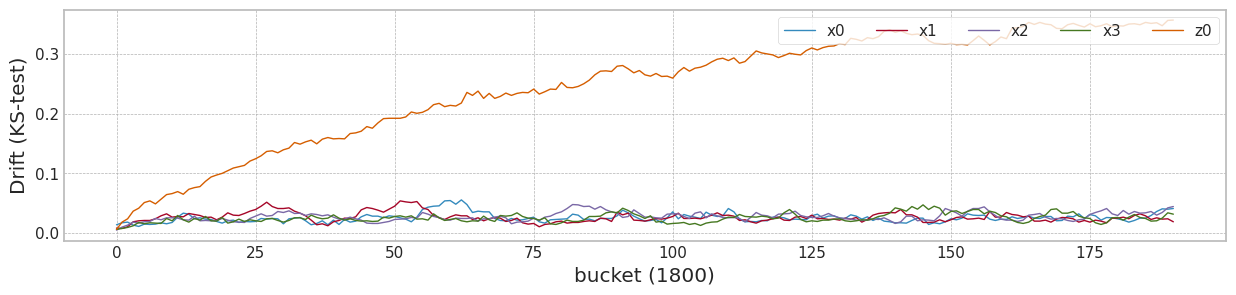

MI Analysis MI Max 0.22806, Min 0.04445, Mean 0.13760, Std 0.07241
cuda:0


100%|██████████| 1000/1000 [00:26<00:00, 37.31it/s]


MSE: 0.23
RMSE: 0.48


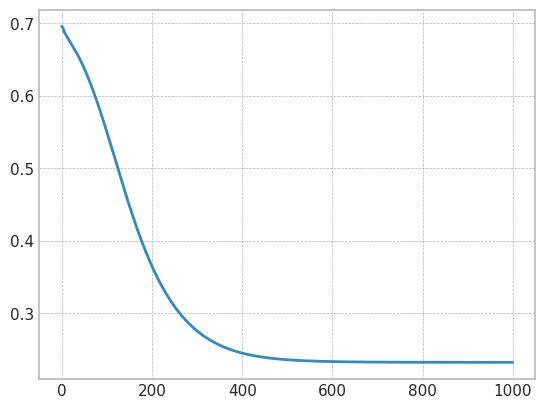

F1 Score:0.90291
Dataset structure X_train, torch.Size([1800, 5]) X_test, torch.Size([1800, 5]) X_live (39800, 5)
Truncate 7200 rows from live_set (39800, 5)


100%|██████████| 191/191 [00:00<00:00, 381.10it/s]


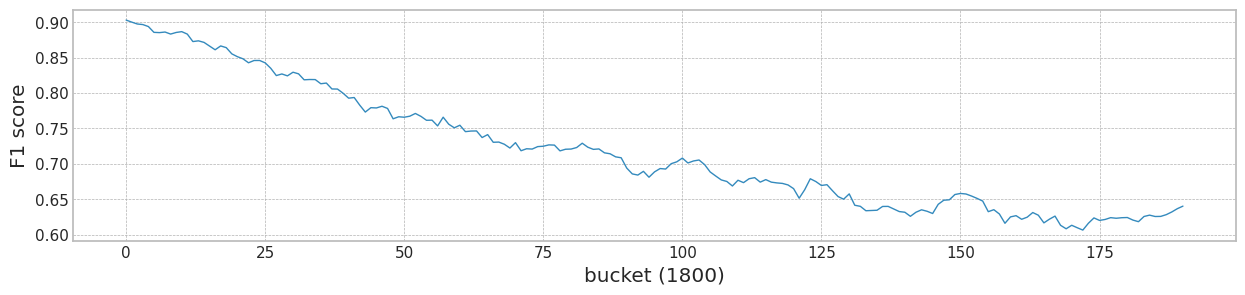

    test_f1   init_f1   mean_f1   last_f1   SUM(MI)
0  0.640502  0.902907  0.717763  0.640502  0.688003


In [134]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
Y = y

train_size = 1800
test_size = 200

X1,Y1 = check_mi_drift(X, Y,train_size, test_size)
model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [135]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
mine = Net(X1.shape[1]).to(device)
optimizer = torch.optim.Adam(mine.parameters(), lr=0.01)
loss_mse = customLoss(mine)
plot_loss = []

x = torch.tensor(X1.values,dtype=torch.float32).to(device)
y = torch.tensor(Y1,dtype=torch.float32).to(device)

for epoch in tqdm(range(300)):
    mine.zero_grad()
    mine_loss = loss_mse(x,y)
    mine_loss.mean().backward()
    optimizer.step()
    plot_loss.append(-mine_loss.cpu().data.numpy())


plot_loss = np.asarray(plot_loss)
df_loss = pd.DataFrame(plot_loss,columns=X1.columns)

cuda:0


100%|██████████| 300/300 [00:02<00:00, 121.51it/s]


<Axes: >

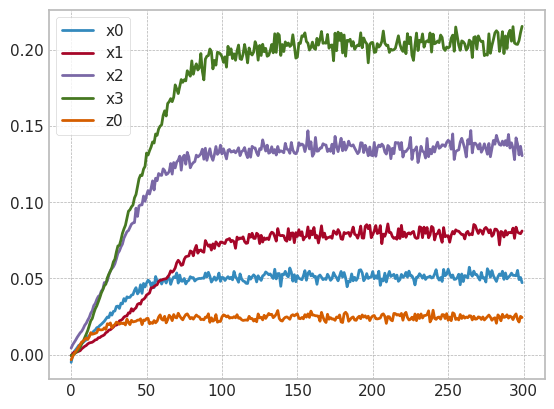

In [136]:
df_loss.plot()

In [137]:
X1['b'] = [int(b) for b in X1.index.values/100]
X1

x0        x1        x2        x3        z0    b
0      0.511187  0.348595  0.564807  0.482506  0.395084    0
1      0.435937  0.524656  0.595436  0.762536  0.606272    0
2      0.479071  0.682932  0.738867  0.596141  0.688060    0
3      0.572894  0.251745  0.392850  0.522275  0.344350    0
4      0.562890  0.613393  0.481594  0.596584  0.670729    0
...         ...       ...       ...       ...       ...  ...
39995  0.332800  0.214564  0.468946  0.614324 -0.069684  399
39996  0.414601  0.252607  0.438192  0.601093  0.984518  399
39997  0.361400  0.558191  0.590386  0.612855  0.528420  399
39998  0.459619  0.212723  0.148134  0.664097  2.043499  399
39999  0.647526  0.377718  0.782096  0.629977  1.643125  399

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 594.51it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9026258205689278
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.64it/s]


mean of drift:
x0    0.025457
x1    0.026437
x2    0.027571
x3    0.025285
z0    0.245739
dtype: float64
Mean F1 for all data: 0.7111527621222895
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.38it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9052054794520549
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.07it/s]


mean of drift:
x0    1.000000
x1    0.556670
x2    0.992024
x3    0.999773
z0    0.776690
dtype: float64
Mean F1 for all data: 0.7491188513274045
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.48it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9002169197396962
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.52it/s]


mean of drift:
x0    0.572266
x1    0.560919
x2    0.806067
x3    0.324828
z0    0.879939
dtype: float64
Mean F1 for all data: 0.26135696071254333
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.79it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9004329004329005
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.27it/s]


mean of drift:
x0    0.351399
x1    0.523179
x2    0.688871
x3    0.277118
z0    0.829901
dtype: float64
Mean F1 for all data: 0.33093902142197784
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.28it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.8971148611867175
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.28it/s]


mean of drift:
x0    0.373362
x1    0.529799
x2    0.153784
x3    0.186265
z0    0.774642
dtype: float64
Mean F1 for all data: 0.5215365864344155
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:50<00:00, 79.75it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.8987547374120195
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.09it/s]


mean of drift:
x0    0.321088
x1    0.472949
x2    0.172711
x3    0.151434
z0    0.670890
dtype: float64
Mean F1 for all data: 0.7306573659448454
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.51it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9039609332609875
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.46it/s]


mean of drift:
x0    0.385413
x1    0.454933
x2    0.245372
x3    0.244985
z0    0.543959
dtype: float64
Mean F1 for all data: 0.8287325294368623
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.54it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9051490514905149
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.10it/s]


mean of drift:
x0    0.340666
x1    0.390814
x2    0.283805
x3    0.182737
z0    0.218072
dtype: float64
Mean F1 for all data: 0.7925167169226843
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.41it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9062330623306233
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.37it/s]


mean of drift:
x0    0.296800
x1    0.337330
x2    0.280759
x3    0.165570
z0    0.183351
dtype: float64
Mean F1 for all data: 0.7921704547624369
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.80it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9060293318848451
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.80it/s]


mean of drift:
x0    0.186972
x1    0.266591
x2    0.214095
x3    0.158694
z0    0.171763
dtype: float64
Mean F1 for all data: 0.7885555783774613
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.13it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9047359825802941
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.09it/s]


mean of drift:
x0    0.146271
x1    0.196632
x2    0.183234
x3    0.132472
z0    0.218037
dtype: float64
Mean F1 for all data: 0.7687762723317689


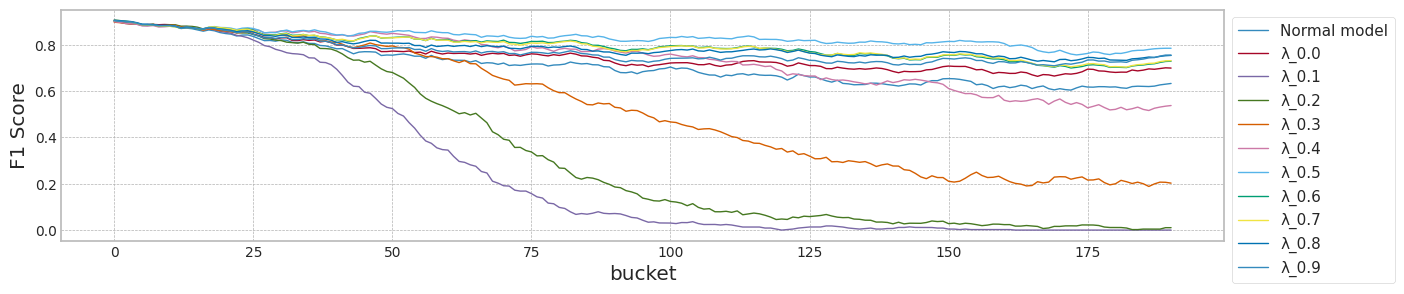

max_mean_lambda= 0.5


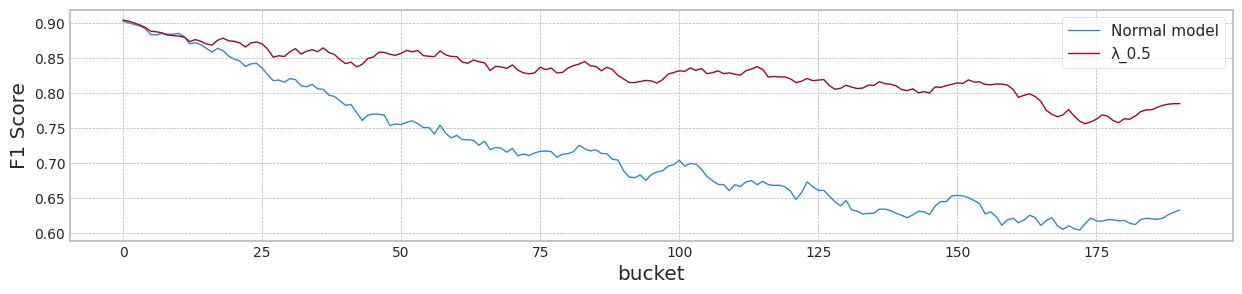

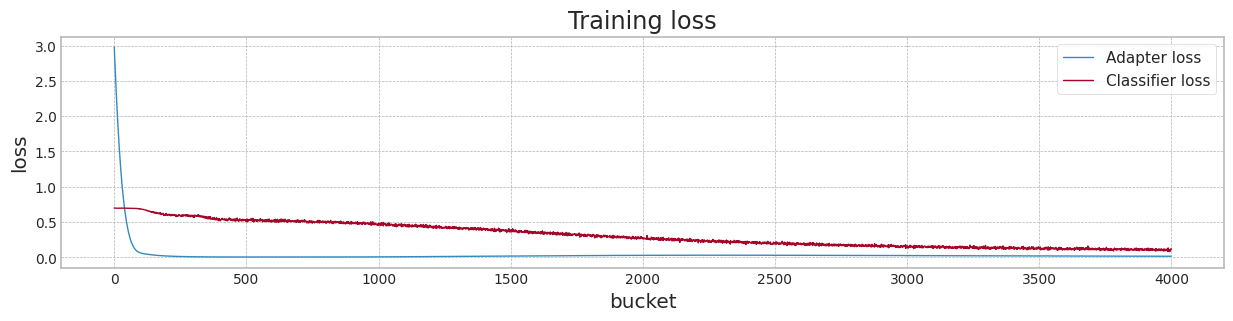

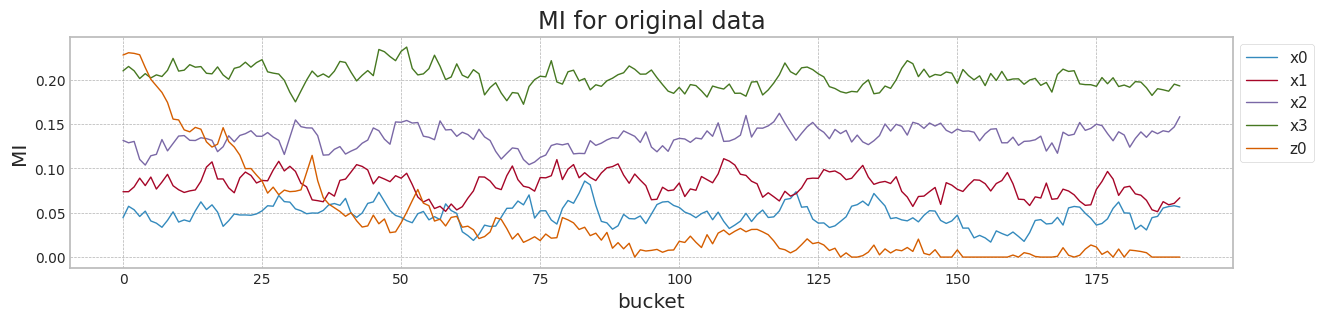

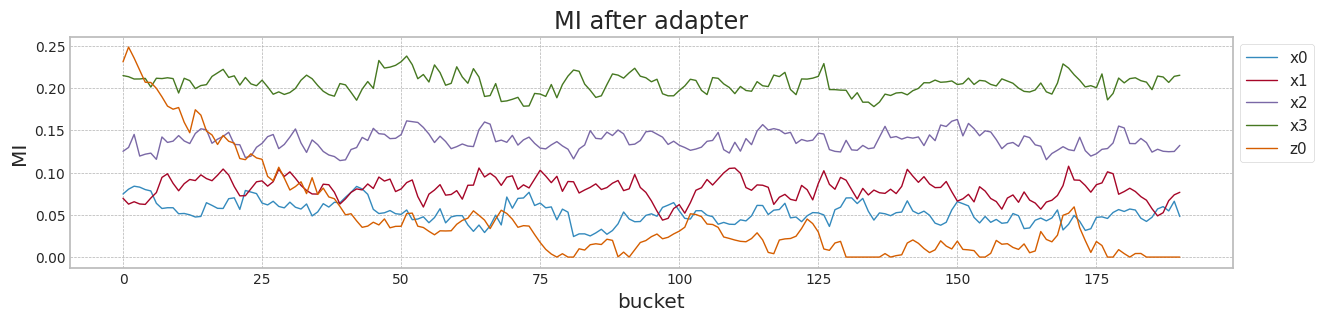

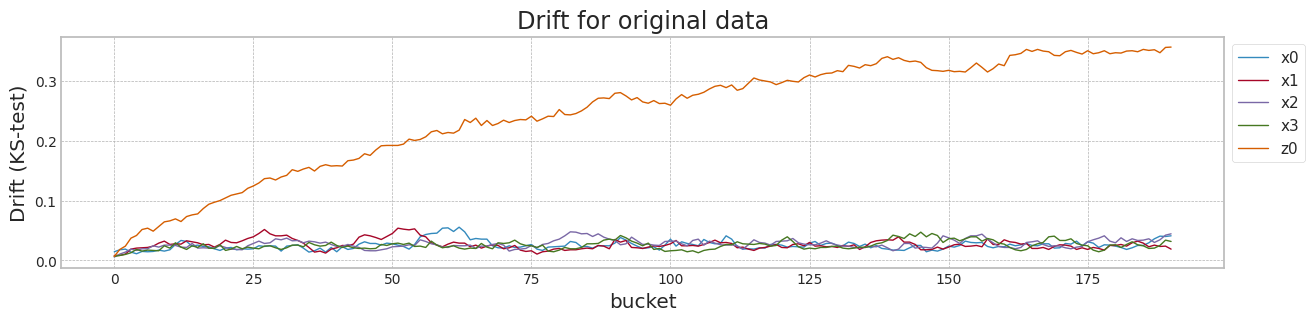

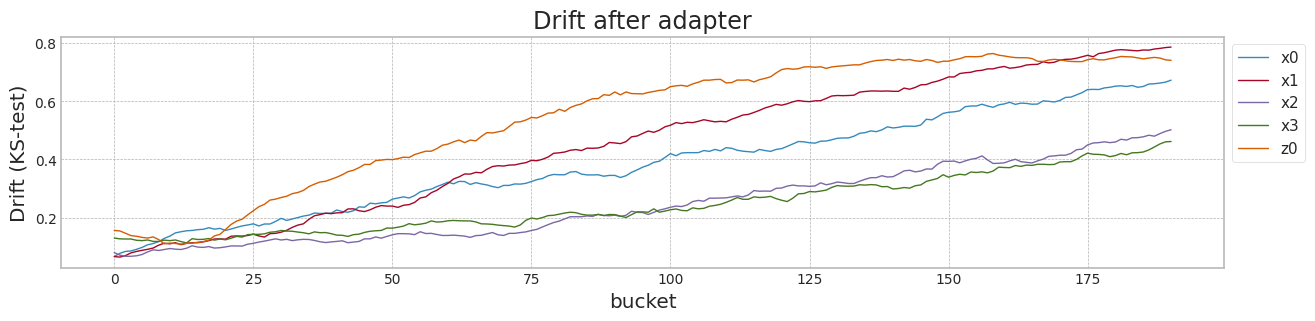

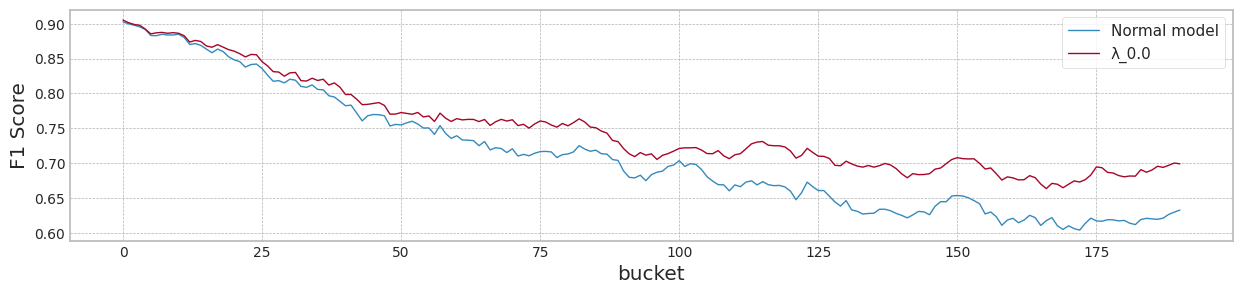

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.902626  0.902626  0.711153  0.632739  0.784381   
1                     0.0  0.905205  0.905205  0.749119  0.699158  0.827880   
2                     0.1  0.900217  0.900217  0.261357  0.000000  0.813826   
3                     0.2  0.900433  0.900433  0.330939  0.010341  0.827107   
4                     0.3  0.897115  0.897115  0.521537  0.202578  0.839390   
5                     0.4  0.898755  0.898755  0.730657  0.537475  0.838398   
6                     0.5  0.903961  0.903961  0.828733  0.784641  0.837689   
7                     0.6  0.905149  0.905149  0.792517  0.728794  0.840713   
8                     0.7  0.906233  0.906233  0.792170  0.731092  0.817715   
9                     0.8  0.906029  0.906029  0.788556  0.753889  0.809985   
10                    0.9  0.904736  0.904736  0.768776  0.754873  0.814255   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.095664   0.075037  0.868745  0.118800  0.757712  0.088996  0.111032   
1   0.094690   0.078392  0.875617  0.101737  0.781587  0.087165  0.094031   
2   0.108597   0.088379  0.899889  0.127516  0.730597  0.092070  0.169292   
3   0.110972   0.091786  0.915722  0.126860  0.751062  0.091036  0.164660   
4   0.110819   0.093021  0.880103  0.131174  0.766790  0.094295  0.113313   
5   0.104036   0.087223  0.906222  0.130375  0.737535  0.096845  0.168688   
6   0.101616   0.085123  0.918792  0.119316  0.776902  0.097985  0.141890   
7   0.102937   0.086541  0.906744  0.117485  0.774697  0.098439  0.132047   
8   0.105107   0.085947  0.905587  0.115214  0.777647  0.097197  0.127939   
9   0.106332   0.086128  0.896765  0.118183  0.763338  0.094623  0.133428   
10  0.100210   0.081597  0.882902  0.115792  0.742941  0.093445  0.139961   

     std 1-2   sum 1+2   std 1+2  
0   0.029804  1.626457  0.207796  
1   0.014572  1.657204  0.188902  
2   0.035446  1.630486  0.219587  
3   0.035824  1.666783  0.217897  
4   0.036879  1.646893  0.225469  
5   0.033530  1.643757  0.227220  
6   0.021331  1.695694  0.217300  
7   0.019046  1.681441  0.215925  
8   0.018018  1.683234  0.212411  
9   0.023560  1.660103  0.212806  
10  0.022347  1.625843  0.209237

In [138]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400)

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

### Dataset 준비

In [139]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [140]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [141]:
x1.shape

(40000, 5)

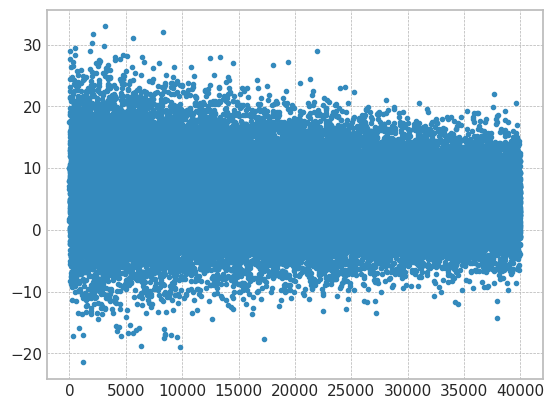

In [142]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

plt.plot(y1_array,'.')

In [143]:
m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

5
21325


### 실험

MI Analysis MI Max 0.22746, Min 0.00677, Mean 0.06988, Std 0.08433
Dataset structure X_train, (1800, 5) X_test, (1800, 5) X_live (39800, 5)
Truncate 7200 rows from live_set (39800, 5)
Search MI & Drift...for X_live_set (191, 1800, 5)


100%|██████████| 191/191 [00:07<00:00, 25.30it/s]


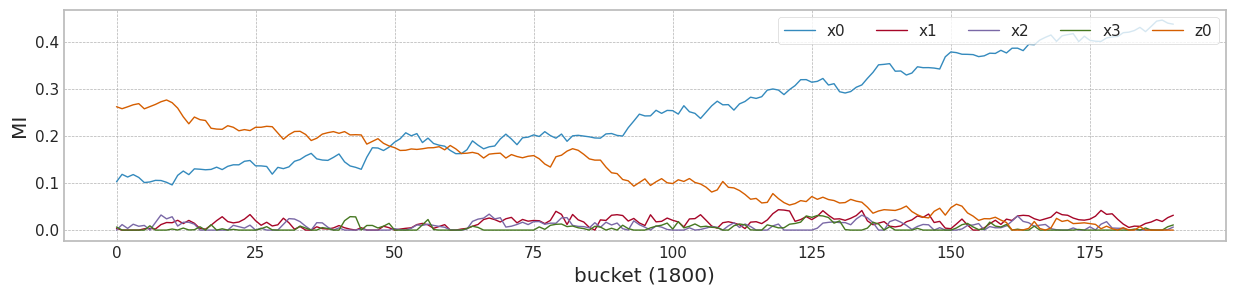

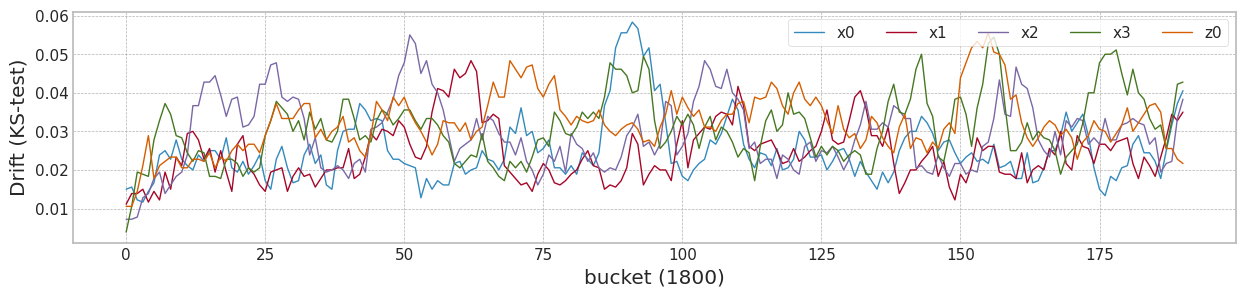

MI Analysis MI Max 0.26184, Min 0.00000, Mean 0.07488, Std 0.10109
cuda:0


100%|██████████| 1000/1000 [00:26<00:00, 37.62it/s]


MSE: 0.05
RMSE: 0.23


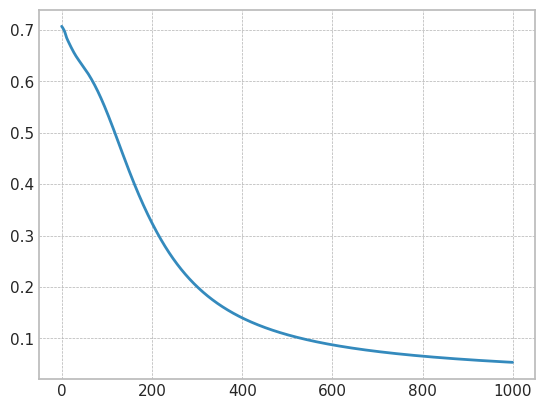

F1 Score:0.99568
Dataset structure X_train, torch.Size([1800, 5]) X_test, torch.Size([1800, 5]) X_live (39800, 5)
Truncate 7200 rows from live_set (39800, 5)


100%|██████████| 191/191 [00:00<00:00, 420.14it/s]


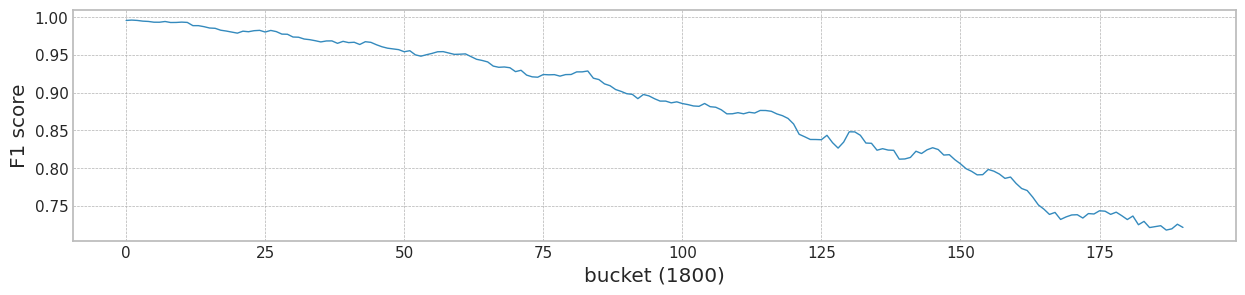

    test_f1   init_f1   mean_f1   last_f1   SUM(MI)
0  0.721577  0.995679  0.882188  0.721577  0.374413


In [144]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

train_size = 1800
test_size = 200

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)
model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [145]:
X1['b'] = [int(b/100) for b in X1.index.values]
X1

x0        x1        x2        x3        z0    b
0      0.519751  0.468030  0.270011  0.516605  0.339159    0
1      0.605565  0.386136  0.467312  0.549700  0.666164    0
2      0.551222  0.433079  0.644682  0.704678  0.471856    0
3      0.335978  0.625620  0.283118  0.494381  0.609888    0
4      0.496805  0.524298  0.566753  0.426693  0.472373    0
...         ...       ...       ...       ...       ...  ...
39995  0.325122  0.364328  0.241452  0.576603  0.717378  399
39996  0.350268  0.453351  0.284085  0.543373  0.701927  399
39997  0.553850  0.305018  0.504892  0.544244  0.491374  399
39998  0.426469  0.502344  0.239389  0.229965  0.775500  399
39999  0.532744  0.616406  0.302647  0.751387  0.511368  399

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 575.08it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9721040189125295
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:07<00:00, 24.01it/s]


mean of drift:
x0    0.024977
x1    0.024340
x2    0.029145
x3    0.030794
z0    0.032225
dtype: float64
Mean F1 for all data: 0.8643210537736058
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.06it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9966394623139702
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.49it/s]


mean of drift:
x0    0.849436
x1    0.729340
x2    0.640838
x3    1.000000
z0    0.733150
dtype: float64
Mean F1 for all data: 0.8810430192363798
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.72it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.981419723677942
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.56it/s]


mean of drift:
x0    0.874008
x1    0.298519
x2    0.758109
x3    0.105320
z0    0.217900
dtype: float64
Mean F1 for all data: 0.2692996726921489
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.50it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9724334600760456
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.71it/s]


mean of drift:
x0    0.845451
x1    0.285442
x2    0.293415
x3    0.094308
z0    0.217670
dtype: float64
Mean F1 for all data: 0.296336787948174
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.60it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9687203791469194
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:07<00:00, 23.91it/s]


mean of drift:
x0    0.841472
x1    0.175410
x2    0.187048
x3    0.070105
z0    0.142228
dtype: float64
Mean F1 for all data: 0.27984568868900406
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.43it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9632075471698113
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.54it/s]


mean of drift:
x0    0.837266
x1    0.065079
x2    0.102150
x3    0.083232
z0    0.148933
dtype: float64
Mean F1 for all data: 0.2742280791172285
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.64it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9609779031499766
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.44it/s]


mean of drift:
x0    0.849055
x1    0.059476
x2    0.073182
x3    0.070750
z0    0.116245
dtype: float64
Mean F1 for all data: 0.25509857431288285
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.62it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9586077140169332
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:07<00:00, 23.90it/s]


mean of drift:
x0    0.844308
x1    0.062202
x2    0.053633
x3    0.059985
z0    0.329052
dtype: float64
Mean F1 for all data: 0.22981467869310204
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.01it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9562352941176471
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.45it/s]


mean of drift:
x0    0.207330
x1    0.082551
x2    0.073517
x3    0.056678
z0    0.270305
dtype: float64
Mean F1 for all data: 0.821548623771188
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.34it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9559925093632959
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.30it/s]


mean of drift:
x0    0.286748
x1    0.092144
x2    0.076658
x3    0.051411
z0    0.100852
dtype: float64
Mean F1 for all data: 0.8749243938345029
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:50<00:00, 79.79it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9565623540401682
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.57it/s]


mean of drift:
x0    0.171734
x1    0.095631
x2    0.087888
x3    0.049546
z0    0.086012
dtype: float64
Mean F1 for all data: 0.8918191205841346


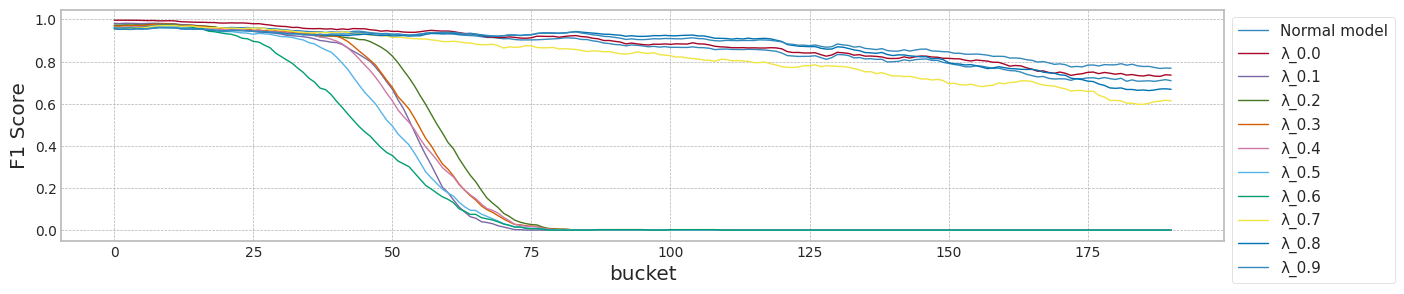

max_mean_lambda= 0.9


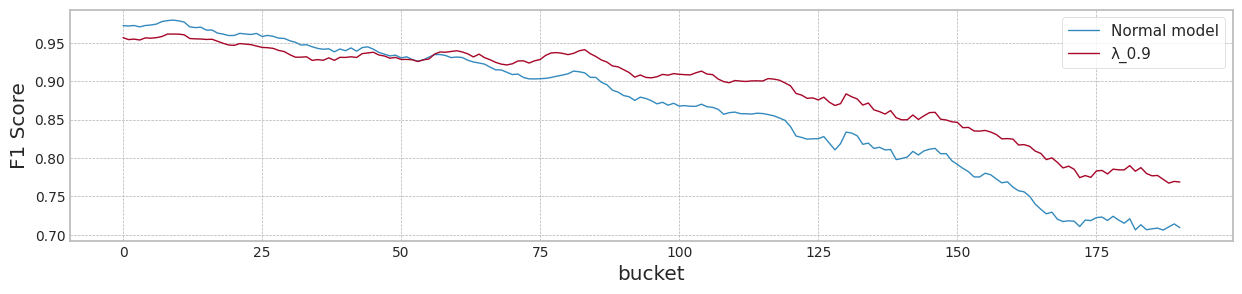

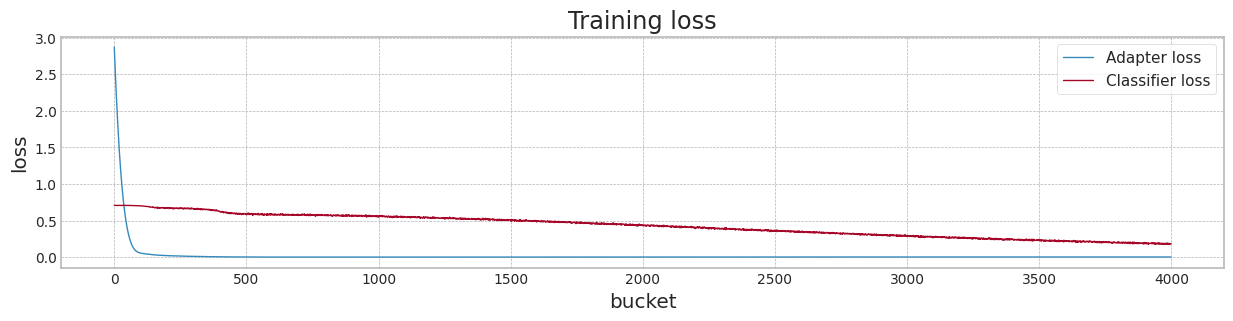

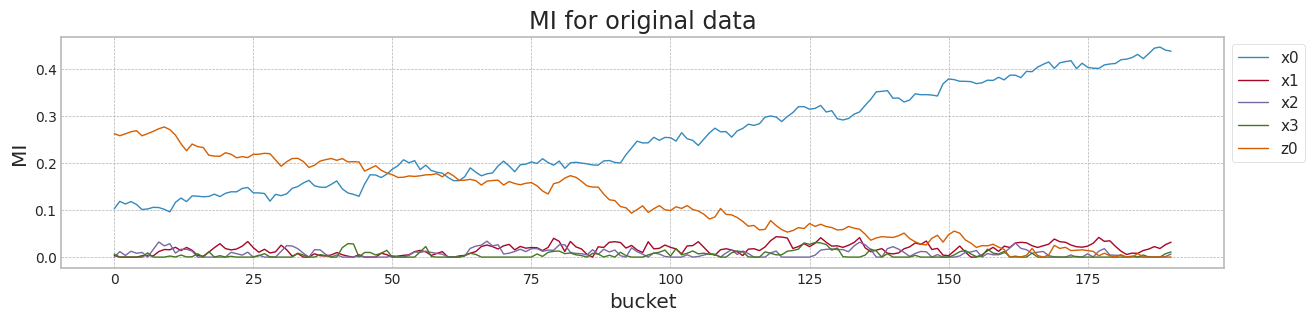

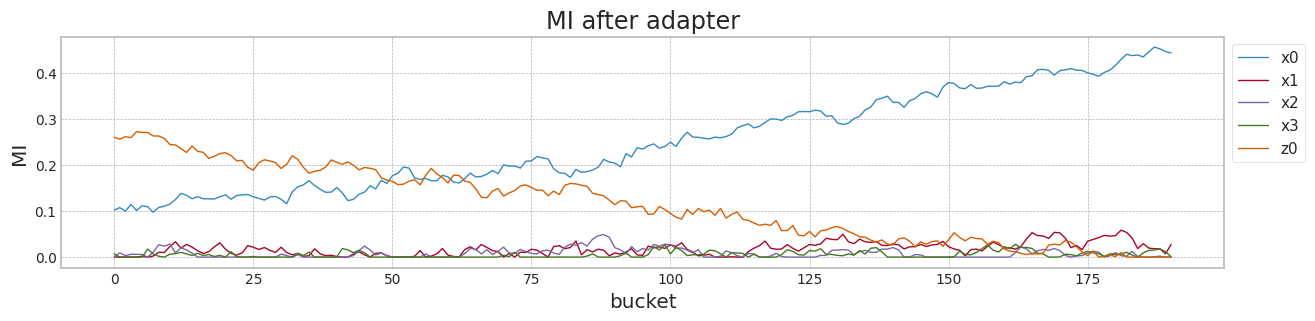

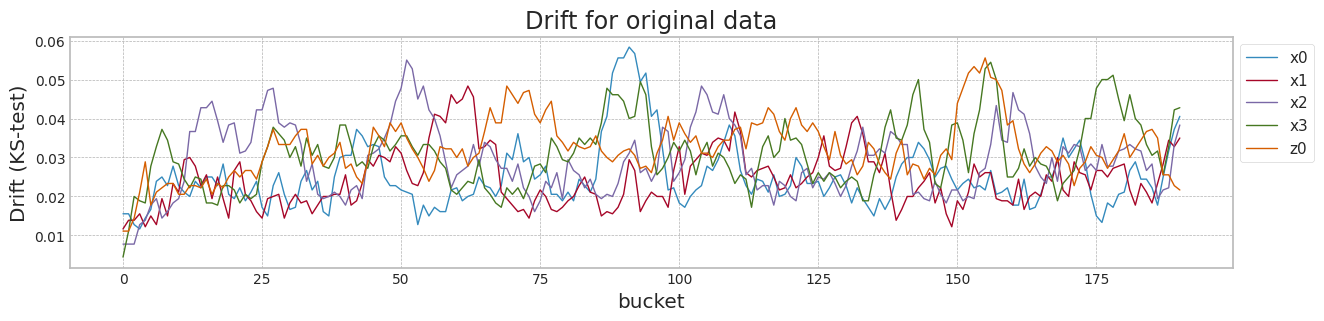

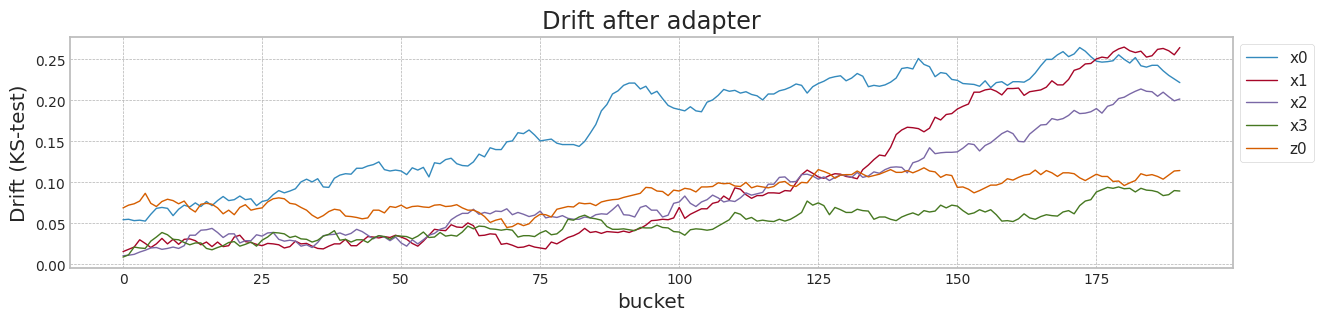

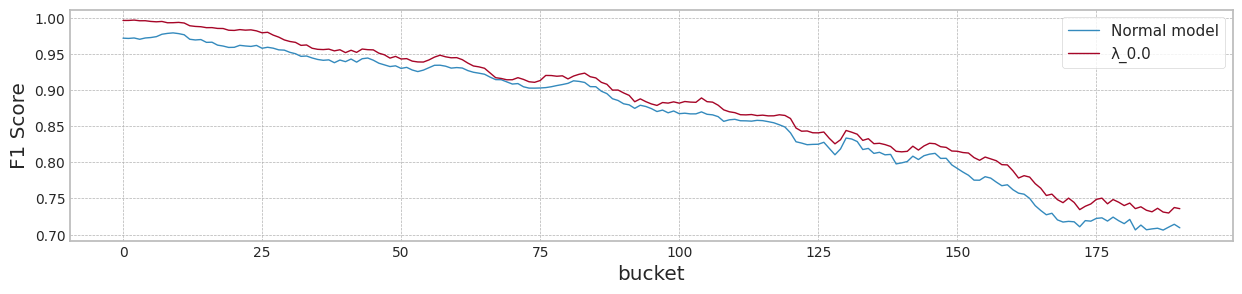

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.972104  0.972104  0.864321  0.709419  0.404505   
1                     0.0  0.996639  0.996639  0.881043  0.735894  0.402987   
2                     0.1  0.981420  0.981420  0.269300  0.000000  0.376543   
3                     0.2  0.972433  0.972433  0.296337  0.000000  0.379484   
4                     0.3  0.968720  0.968720  0.279846  0.000000  0.425681   
5                     0.4  0.963208  0.963208  0.274228  0.000000  0.380848   
6                     0.5  0.960978  0.960978  0.255099  0.000000  0.397220   
7                     0.6  0.958608  0.958608  0.229815  0.000000  0.405362   
8                     0.7  0.956235  0.956235  0.821549  0.613587  0.424412   
9                     0.8  0.955993  0.955993  0.874924  0.668497  0.400810   
10                    0.9  0.956562  0.956562  0.891819  0.768766  0.392507   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.116157   0.046986  0.416156  0.110673  0.386578  0.111651  0.029578   
1   0.099127   0.039947  0.439005  0.100837  0.352685  0.100200  0.086320   
2   0.110124   0.041466  0.454309  0.111302  0.368236  0.106418  0.086074   
3   0.115337   0.043769  0.413582  0.116071  0.354047  0.108740  0.059535   
4   0.111224   0.047346  0.425260  0.112762  0.335232  0.110009  0.090028   
5   0.111785   0.042573  0.422711  0.118072  0.337516  0.105044  0.085195   
6   0.113672   0.045153  0.415318  0.117415  0.361781  0.114607  0.053537   
7   0.113525   0.046019  0.411943  0.117569  0.378434  0.107249  0.033510   
8   0.115268   0.048921  0.421293  0.119534  0.377252  0.109827  0.044040   
9   0.113496   0.045491  0.417045  0.116814  0.394090  0.118333  0.022955   
10  0.113425   0.044520  0.410224  0.113663  0.388782  0.115080  0.021442   

     std 1-2   sum 1+2   std 1+2  
0   0.000978  0.802734  0.222325  
1   0.000637  0.791690  0.201036  
2   0.004884  0.822545  0.217720  
3   0.007331  0.767629  0.224811  
4   0.002754  0.760493  0.222771  
5   0.013028  0.760227  0.223116  
6   0.002807  0.777099  0.232022  
7   0.010320  0.790377  0.224818  
8   0.009706  0.798545  0.229361  
9   0.001519  0.811136  0.235147  
10  0.001417  0.799006  0.228744

In [146]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400)

## synthetic data의 생성 (Case #3 MI의 증감(상대적), Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

### Dataset 준비

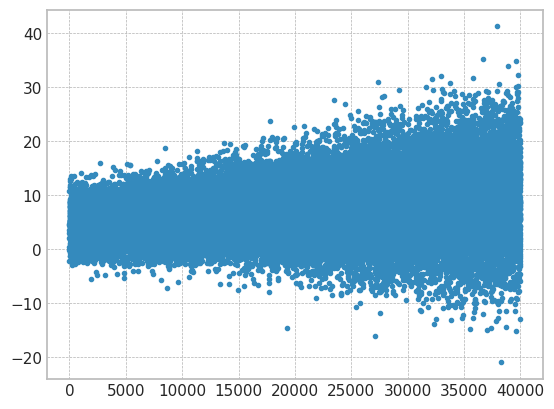

In [147]:
import matplotlib.pyplot as plt

seed_everything(2)

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = []
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0+10*ii/40000, 5*cor_const * ii)
    e1 = 0.0 #np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x2[ii])+e1)

plt.plot(y2_array,'.')

In [148]:
m = 5 #np.mean(y2_array)
print(m)
y2 = [1 if y_ > m else 0 for y_ in y2_array]
sum(y2)

5


26135

### 실험

MI Analysis MI Max 0.22487, Min 0.00191, Mean 0.07138, Std 0.08241
Dataset structure X_train, (1800, 5) X_test, (1800, 5) X_live (39800, 5)
Truncate 7200 rows from live_set (39800, 5)
Search MI & Drift...for X_live_set (191, 1800, 5)


100%|██████████| 191/191 [00:07<00:00, 25.61it/s]


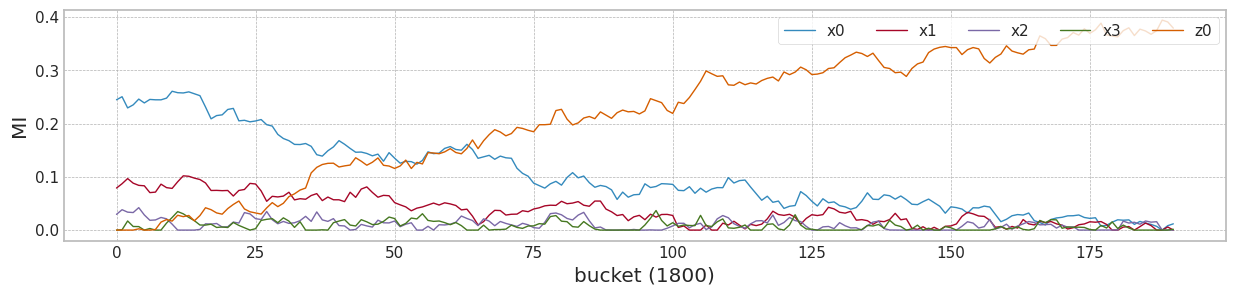

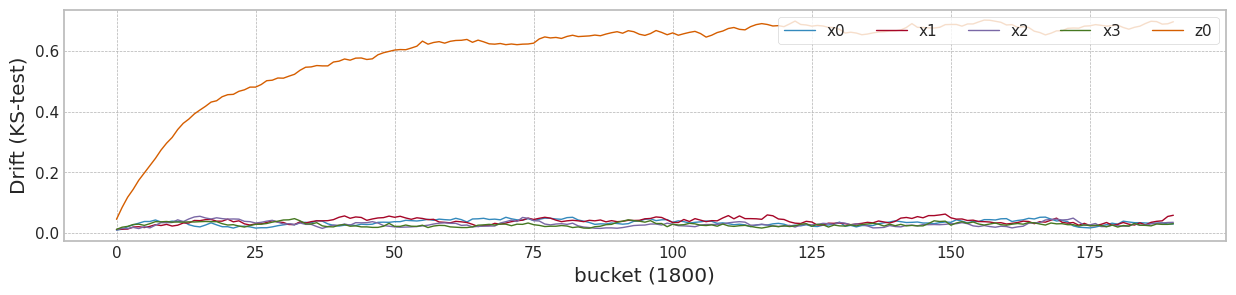

In [149]:
columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)

train_size = 1800
test_size = 200

X1,Y1 = check_mi_drift(X2, y2,train_size, test_size)

In [150]:
X1['b'] = [int(b/100) for b in X1.index.values]
X1

x0        x1        x2        x3        z0    b
0      0.391378  0.179737  0.412932  0.754981  0.336829    0
1      0.439860  0.516005  0.490105  0.540805  0.398226    0
2      0.160132  0.417404  0.389905  0.423808  0.347760    0
3      0.668025  0.621269  0.663604  0.508593  0.540260    0
4      0.206230  0.473113  0.366847  0.584109  0.361078    0
...         ...       ...       ...       ...       ...  ...
39995  0.321563  0.552908  0.399885  0.610627  3.089269  399
39996  0.380574  0.622177  0.454242  0.441404  0.777635  399
39997  0.370265  0.491261  0.156487  0.514722  5.363135  399
39998  0.388943  0.572886  0.872513  0.683365 -0.954199  399
39999  0.406888  0.446354  0.462540  0.510277  0.229368  399

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 563.73it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9579735175590097
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:07<00:00, 23.98it/s]


mean of drift:
x0    0.033307
x1    0.038115
x2    0.028214
x3    0.026774
z0    0.603037
dtype: float64
Mean F1 for all data: 0.8797823750368523
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:50<00:00, 79.99it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9988545246277205
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:07<00:00, 23.91it/s]


mean of drift:
x0    0.621318
x1    0.683365
x2    1.000000
x3    1.000000
z0    0.817446
dtype: float64
Mean F1 for all data: 0.9547930263370427
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.56it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9874285714285714
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.68it/s]


mean of drift:
x0    0.631291
x1    0.549052
x2    0.739002
x3    0.585032
z0    0.592699
dtype: float64
Mean F1 for all data: 0.348947903438395
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.47it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9822958309537406
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.69it/s]


mean of drift:
x0    0.577065
x1    0.537749
x2    0.482987
x3    0.492341
z0    0.327914
dtype: float64
Mean F1 for all data: 0.3754545714050285
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.13it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9754426042261564
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:07<00:00, 24.18it/s]


mean of drift:
x0    0.521995
x1    0.234642
x2    0.288470
x3    0.575029
z0    0.716335
dtype: float64
Mean F1 for all data: 0.45783337330306484
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.17it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.967816091954023
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:07<00:00, 23.98it/s]


mean of drift:
x0    0.758630
x1    0.301763
x2    0.183066
x3    0.596905
z0    0.943173
dtype: float64
Mean F1 for all data: 0.19916264646573473
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.01it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9493670886075949
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:07<00:00, 23.90it/s]


mean of drift:
x0    0.743205
x1    0.401271
x2    0.274331
x3    0.501370
z0    0.910474
dtype: float64
Mean F1 for all data: 0.2132184149877999
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.44it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9351692484222606
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:07<00:00, 24.46it/s]


mean of drift:
x0    0.726617
x1    0.176792
x2    0.355052
x3    0.425099
z0    0.837647
dtype: float64
Mean F1 for all data: 0.21163718413952648
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.13it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9298345693097548
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:07<00:00, 23.92it/s]


mean of drift:
x0    0.698077
x1    0.112519
x2    0.338188
x3    0.329857
z0    0.666239
dtype: float64
Mean F1 for all data: 0.2449001664075601
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.22it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9335604770017035
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:07<00:00, 24.09it/s]


mean of drift:
x0    0.502810
x1    0.528656
x2    0.284607
x3    0.213572
z0    0.619497
dtype: float64
Mean F1 for all data: 0.5500685925557015
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.09it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9375709421112373
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:07<00:00, 24.16it/s]


mean of drift:
x0    0.101149
x1    0.433685
x2    0.234959
x3    0.122621
z0    0.604540
dtype: float64
Mean F1 for all data: 0.8171397425418371


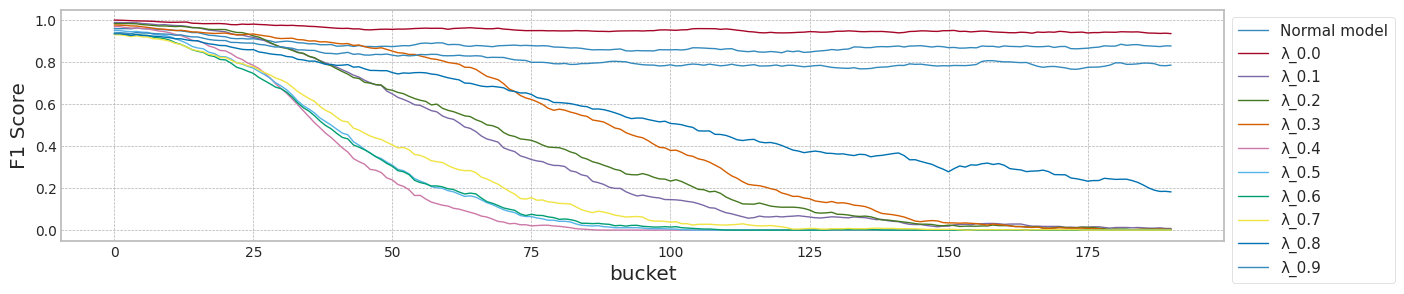

max_mean_lambda= 0.0


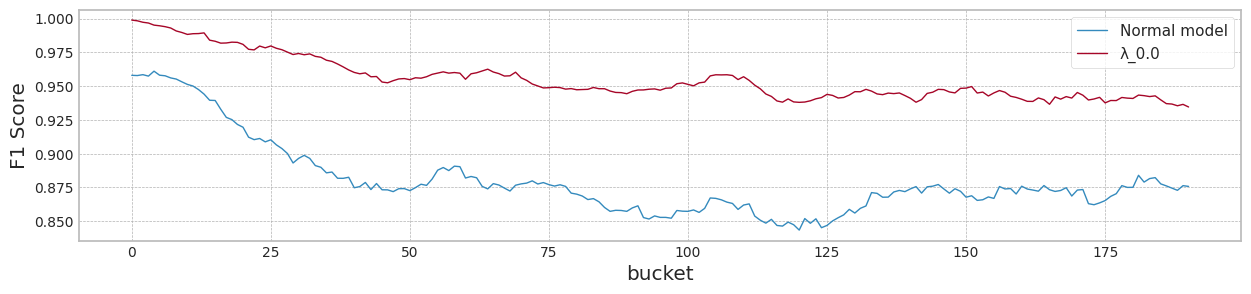

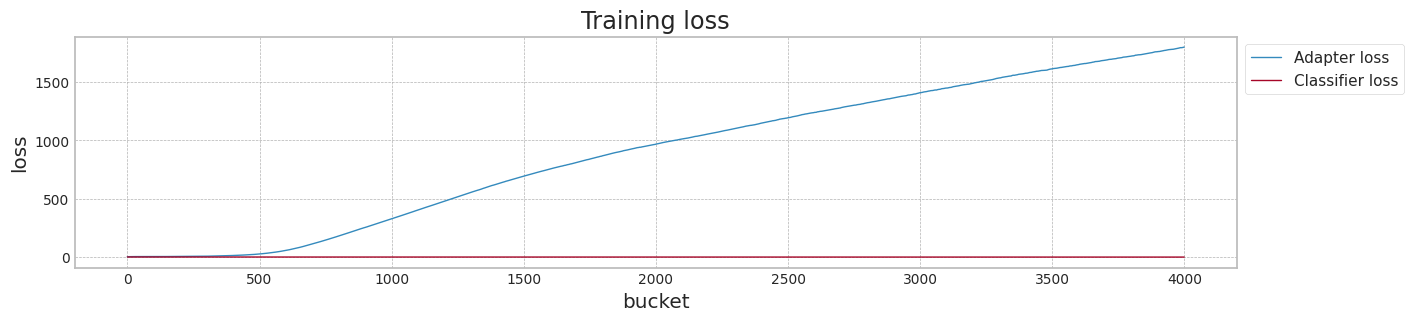

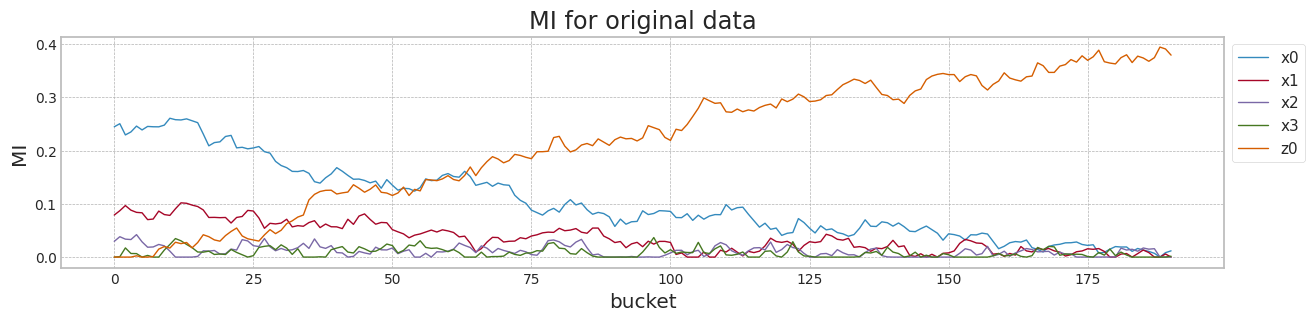

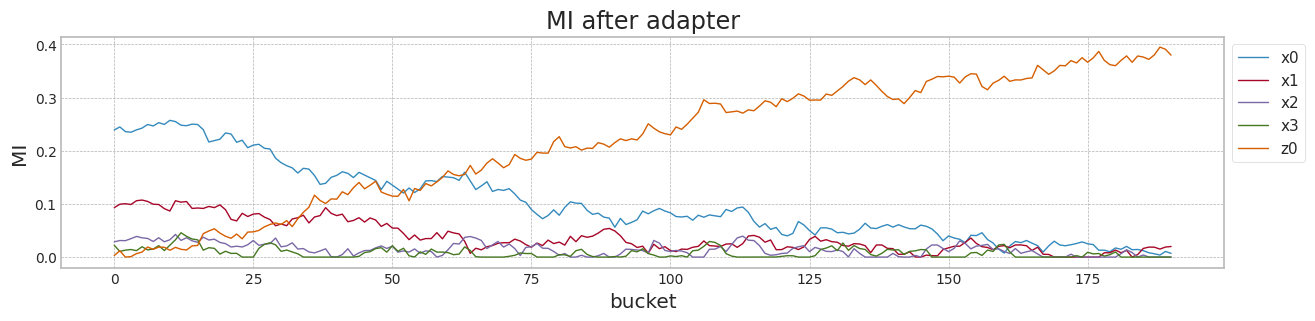

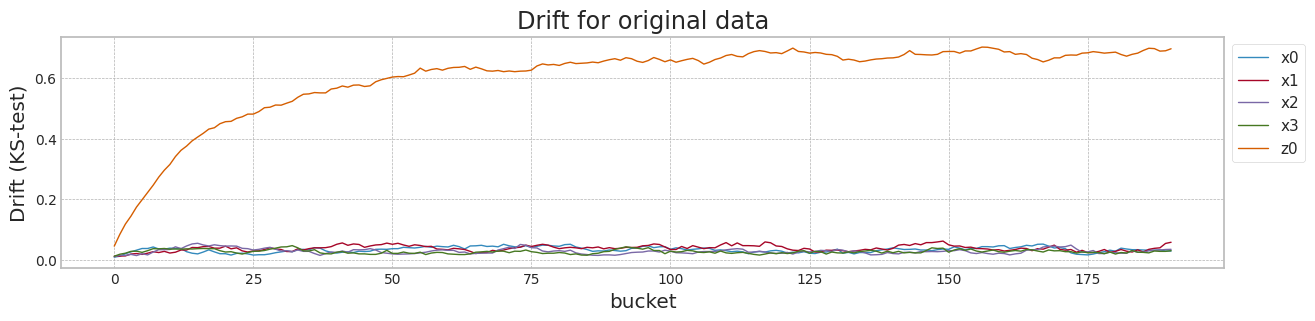

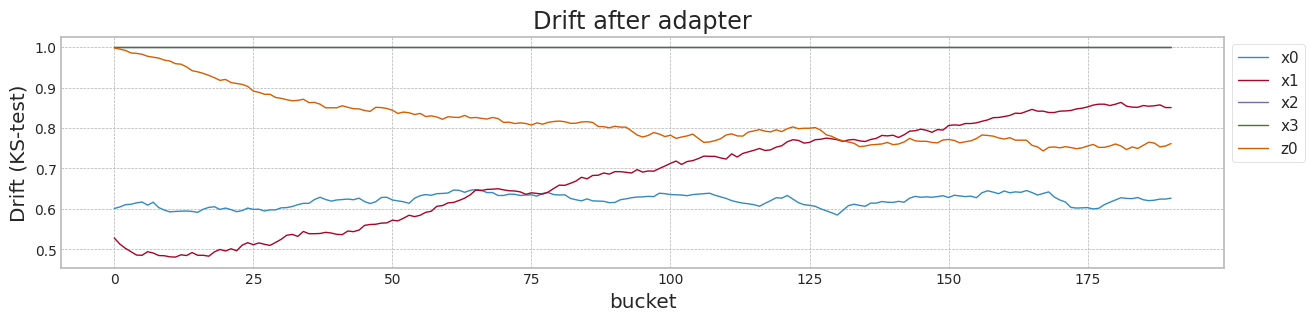

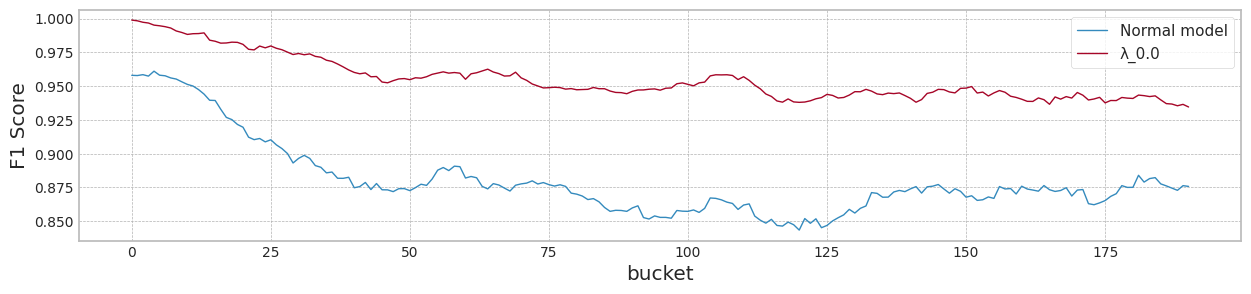

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.957974  0.957974  0.879782  0.875745  0.357895   
1                     0.0  0.998855  0.998855  0.954793  0.934534  0.387186   
2                     0.1  0.987429  0.987429  0.348948  0.007686  0.393642   
3                     0.2  0.982296  0.982296  0.375455  0.003082  0.397296   
4                     0.3  0.975443  0.975443  0.457833  0.003082  0.398949   
5                     0.4  0.967816  0.967816  0.199163  0.000000  0.394571   
6                     0.5  0.949367  0.949367  0.213218  0.000000  0.427636   
7                     0.6  0.935169  0.935169  0.211637  0.000000  0.410194   
8                     0.7  0.929835  0.929835  0.244900  0.000000  0.411910   
9                     0.8  0.933560  0.933560  0.550069  0.181581  0.418336   
10                    0.9  0.937571  0.937571  0.817140  0.784588  0.398709   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.094693   0.033890  0.401104  0.095670  0.372965  0.099913  0.028139   
1   0.086897   0.033645  0.394582  0.089192  0.384934  0.093283  0.009648   
2   0.091736   0.036111  0.408395  0.088413  0.392006  0.096415  0.016388   
3   0.091959   0.036535  0.415640  0.087748  0.386636  0.099025  0.029004   
4   0.094463   0.037686  0.424605  0.091948  0.354502  0.107392  0.070103   
5   0.108274   0.042722  0.423801  0.094523  0.375730  0.107179  0.048071   
6   0.103486   0.044255  0.495742  0.094385  0.387479  0.108227  0.108263   
7   0.109353   0.044856  0.443584  0.097301  0.408472  0.106278  0.035112   
8   0.111297   0.045844  0.410657  0.095625  0.381359  0.114339  0.029298   
9   0.105669   0.044205  0.402647  0.108206  0.413271  0.110380  0.010624   
10  0.106373   0.042412  0.398444  0.106852  0.351455  0.111664  0.046989   

     std 1-2   sum 1+2   std 1+2  
0   0.004242  0.774068  0.195583  
1   0.004091  0.779515  0.182475  
2   0.008001  0.800401  0.184828  
3   0.011276  0.802277  0.186773  
4   0.015444  0.779106  0.199340  
5   0.012656  0.799531  0.201702  
6   0.013842  0.883221  0.202611  
7   0.008977  0.852055  0.203578  
8   0.018714  0.792016  0.209964  
9   0.002174  0.815918  0.218587  
10  0.004812  0.749899  0.218515

In [151]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400)

## synthetic data의 생성 (Case #4 MI의 고정, Drift의 증가)

### Dataset 준비

In [152]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


### 실험

MI Analysis MI Max 0.20278, Min 0.05089, Mean 0.11172, Std 0.05282
Dataset structure X_train, (1800, 5) X_test, (1800, 5) X_live (39800, 5)
Truncate 7200 rows from live_set (39800, 5)
Search MI & Drift...for X_live_set (191, 1800, 5)


100%|██████████| 191/191 [00:07<00:00, 25.53it/s]


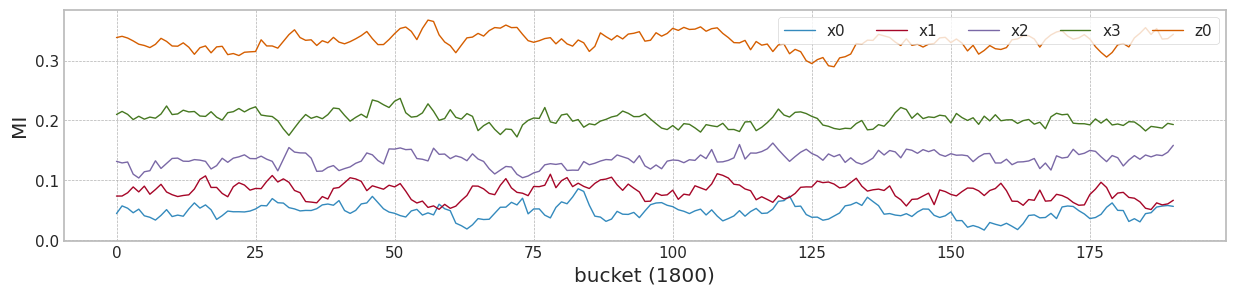

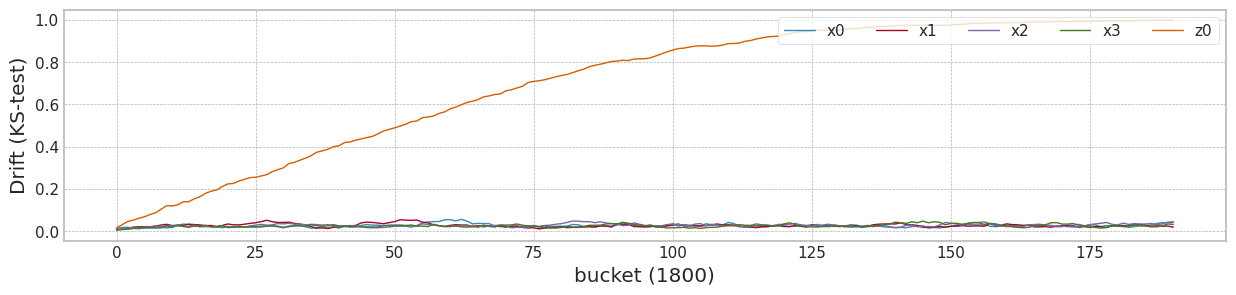

In [153]:
columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)

train_size = 1800
test_size = 200

X1,Y1 = check_mi_drift(X3, y3,train_size, test_size)

In [154]:
X1['b'] = [int(b/100) for b in X1.index.values]
X1

x0        x1        x2        x3        z0    b
0      0.511187  0.348595  0.564807  0.482506  0.503588    0
1      0.435937  0.524656  0.595436  0.762536  0.617637    0
2      0.479071  0.682932  0.738867  0.596141  0.364513    0
3      0.572894  0.251745  0.392850  0.522275  0.371604    0
4      0.562890  0.613393  0.481594  0.596584  0.638879    0
...         ...       ...       ...       ...       ...  ...
39995  0.332800  0.214564  0.468946  0.614324  1.080212  399
39996  0.414601  0.252607  0.438192  0.601093  1.097577  399
39997  0.361400  0.558191  0.590386  0.612855  1.454822  399
39998  0.459619  0.212723  0.148134  0.664097  1.259975  399
39999  0.647526  0.377718  0.782096  0.629977  1.451896  399

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 578.97it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9285714285714285
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:07<00:00, 24.01it/s]


mean of drift:
x0    0.025457
x1    0.026437
x2    0.027571
x3    0.025285
z0    0.703194
dtype: float64
Mean F1 for all data: 0.7405112851250151
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.07it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9288840262582058
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 22.86it/s]


mean of drift:
x0    1.000000
x1    0.519529
x2    0.736806
x3    0.999921
z0    0.827077
dtype: float64
Mean F1 for all data: 0.7774686637687243
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 80.10it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9264069264069265
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 22.76it/s]


mean of drift:
x0    0.464738
x1    0.582609
x2    0.864250
x3    0.530602
z0    0.345436
dtype: float64
Mean F1 for all data: 0.8995779395776826
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:50<00:00, 79.09it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9261455525606468
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 22.66it/s]


mean of drift:
x0    0.528153
x1    0.727359
x2    0.837501
x3    0.440971
z0    0.335777
dtype: float64
Mean F1 for all data: 0.9023219642343787
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:50<00:00, 79.78it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9254054054054054
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 22.92it/s]


mean of drift:
x0    0.339799
x1    0.546696
x2    0.465620
x3    0.341326
z0    0.372152
dtype: float64
Mean F1 for all data: 0.7904919233343113
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:50<00:00, 79.11it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9271451699946033
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 22.60it/s]


mean of drift:
x0    0.327973
x1    0.459654
x2    0.174555
x3    0.390675
z0    0.366469
dtype: float64
Mean F1 for all data: 0.758563987951353
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:50<00:00, 79.56it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9283018867924527
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 22.84it/s]


mean of drift:
x0    0.593200
x1    0.464904
x2    0.364616
x3    0.216268
z0    0.402493
dtype: float64
Mean F1 for all data: 0.7542301544295162
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:50<00:00, 79.82it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9270664505672609
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 22.83it/s]


mean of drift:
x0    0.219444
x1    0.381809
x2    0.349343
x3    0.177461
z0    0.356233
dtype: float64
Mean F1 for all data: 0.7694470807118264
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:50<00:00, 79.16it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9269602577873255
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 22.93it/s]


mean of drift:
x0    0.281475
x1    0.342702
x2    0.296161
x3    0.151067
z0    0.468008
dtype: float64
Mean F1 for all data: 0.7500995548280405
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:50<00:00, 79.40it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9258861439312567
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 22.94it/s]


mean of drift:
x0    0.191195
x1    0.231082
x2    0.220948
x3    0.221614
z0    0.558392
dtype: float64
Mean F1 for all data: 0.7403942497714006
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:50<00:00, 79.20it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9248120300751881
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 22.82it/s]


mean of drift:
x0    0.108822
x1    0.155980
x2    0.145326
x3    0.116201
z0    0.585646
dtype: float64
Mean F1 for all data: 0.7433722835289586


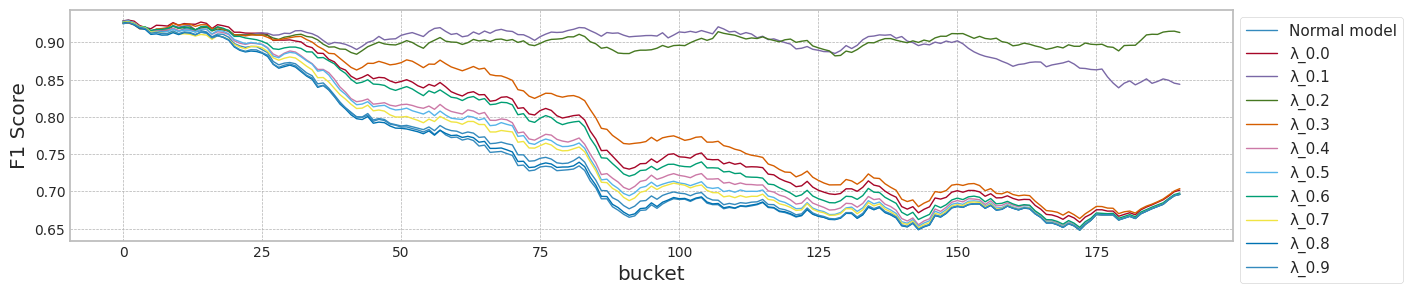

max_mean_lambda= 0.2


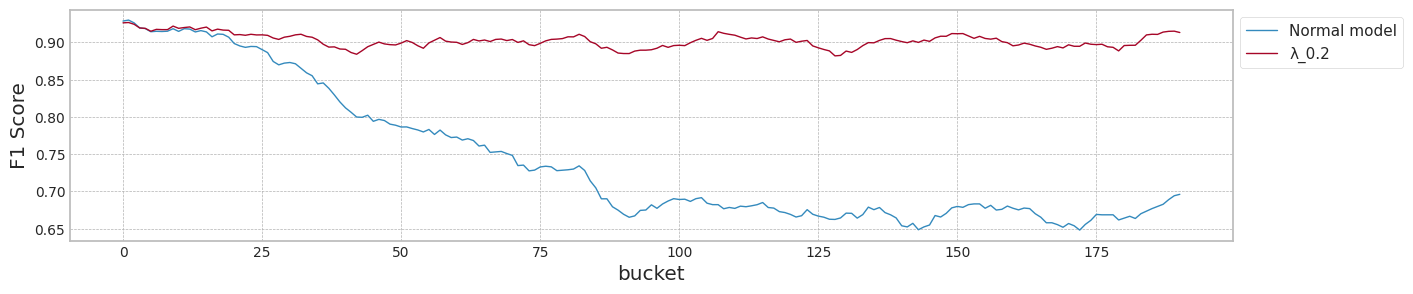

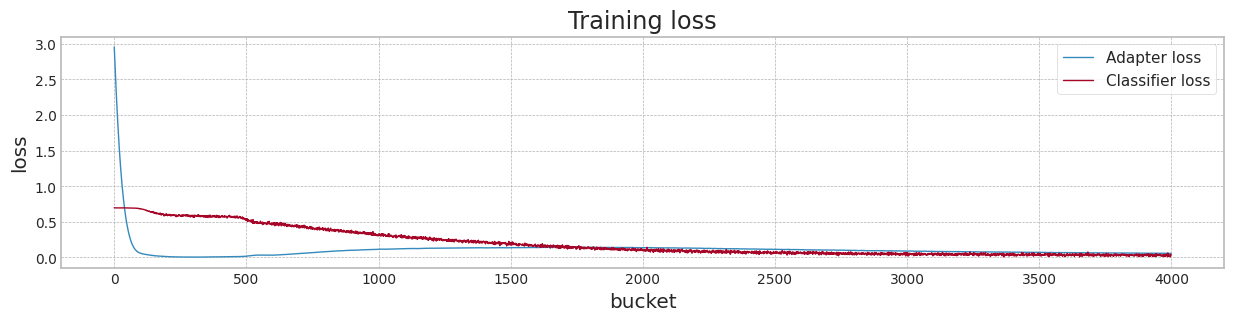

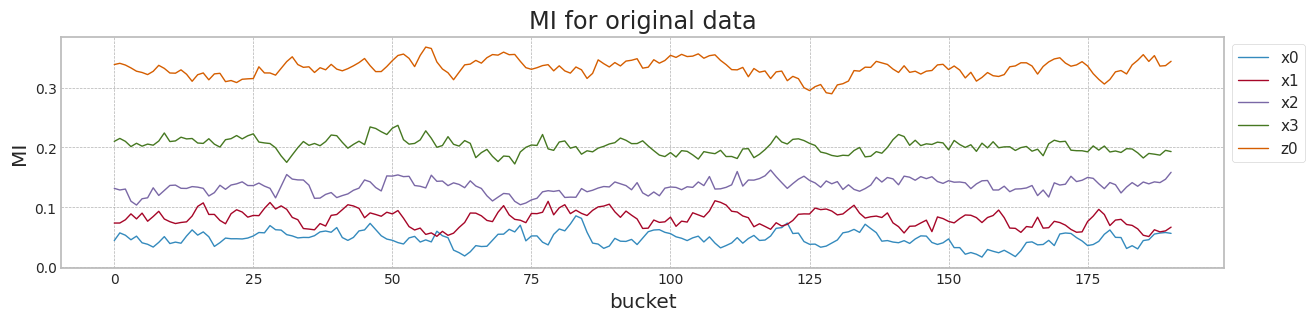

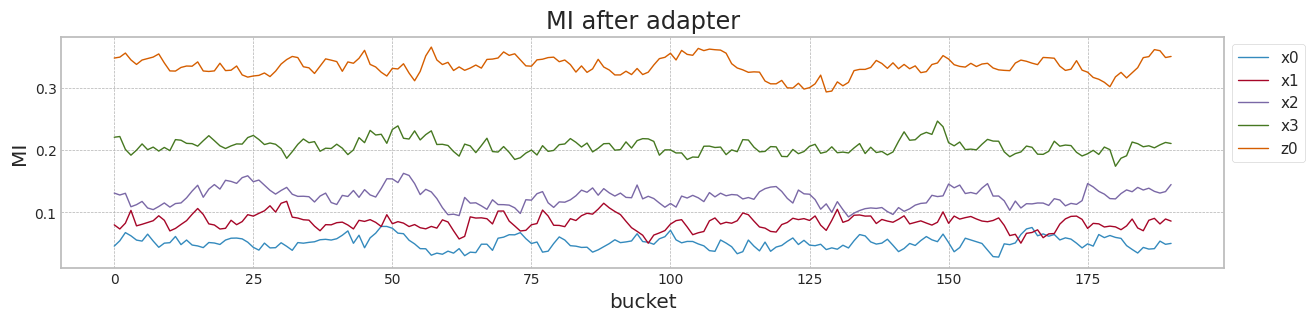

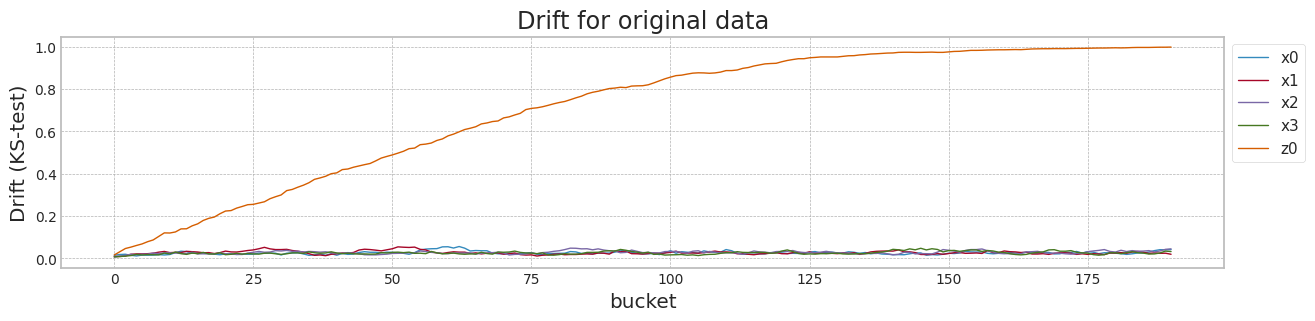

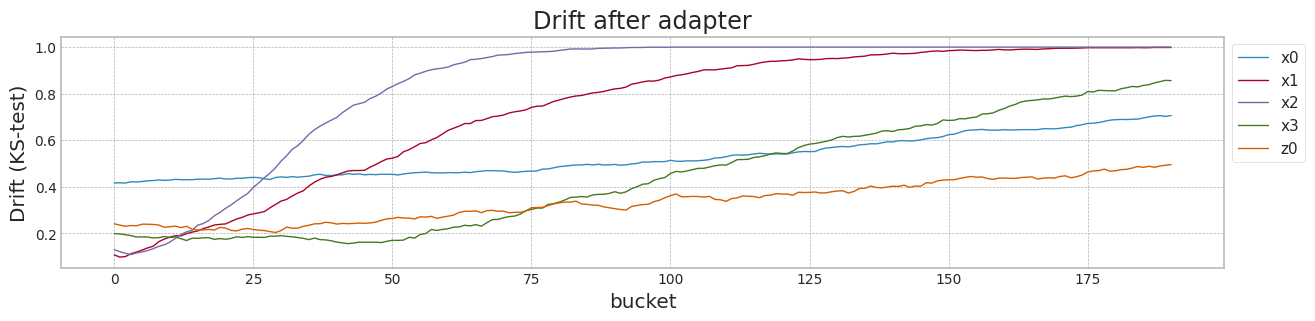

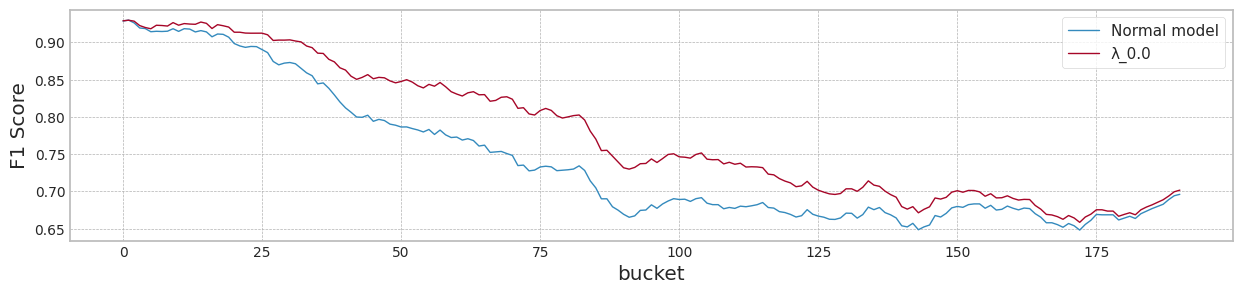

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.928571  0.928571  0.740511  0.696125  0.916524   
1                     0.0  0.928884  0.928884  0.777469  0.701716  0.920891   
2                     0.1  0.926407  0.926407  0.899578  0.843731  0.959998   
3                     0.2  0.926146  0.926146  0.902322  0.913180  0.948732   
4                     0.3  0.925405  0.925405  0.790492  0.703772  0.924216   
5                     0.4  0.927145  0.927145  0.758564  0.696629  0.915742   
6                     0.5  0.928302  0.928302  0.754230  0.696125  0.919125   
7                     0.6  0.927066  0.927066  0.769447  0.697894  0.927350   
8                     0.7  0.926960  0.926960  0.750100  0.696125  0.931016   
9                     0.8  0.925886  0.925886  0.740394  0.696125  0.948960   
10                    0.9  0.924812  0.924812  0.743372  0.696125  0.912690   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.126690   0.116114  0.938647  0.124392  0.847101  0.126034  0.091547   
1   0.121669   0.112044  0.959382  0.122244  0.876376  0.126528  0.083006   
2   0.135291   0.129879  0.980117  0.133075  0.895991  0.122712  0.084126   
3   0.135959   0.128989  0.938625  0.138857  0.811967  0.138311  0.126658   
4   0.138375   0.127888  0.947980  0.135823  0.838697  0.136178  0.109283   
5   0.136206   0.124730  0.980658  0.129357  0.863230  0.138411  0.117428   
6   0.134693   0.123799  0.979584  0.131136  0.825604  0.137000  0.153980   
7   0.136732   0.126799  0.951551  0.134503  0.810418  0.134987  0.141133   
8   0.137107   0.127649  0.960935  0.134685  0.837593  0.135708  0.123342   
9   0.133051   0.126260  0.956413  0.138035  0.833095  0.137898  0.123318   
10  0.140579   0.128305  0.974474  0.139033  0.798802  0.140889  0.175672   

     std 1-2   sum 1+2   std 1+2  
0   0.001642  1.785748  0.250427  
1   0.004285  1.835759  0.248772  
2   0.010363  1.876107  0.255787  
3   0.000546  1.750593  0.277168  
4   0.000354  1.786677  0.272001  
5   0.009055  1.843888  0.267768  
6   0.005863  1.805189  0.268136  
7   0.000484  1.761969  0.269489  
8   0.001023  1.798527  0.270393  
9   0.000137  1.789508  0.275933  
10  0.001856  1.773276  0.279922

In [155]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400)

## synthetic data의 생성 (Case #5 - Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우)

### Dataset 준비

In [156]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


### 실험

MI Analysis MI Max 0.14553, Min 0.02498, Mean 0.08409, Std 0.04454
Dataset structure X_train, (1800, 5) X_test, (1800, 5) X_live (39800, 5)
Truncate 7200 rows from live_set (39800, 5)
Search MI & Drift...for X_live_set (191, 1800, 5)


100%|██████████| 191/191 [00:07<00:00, 24.40it/s]


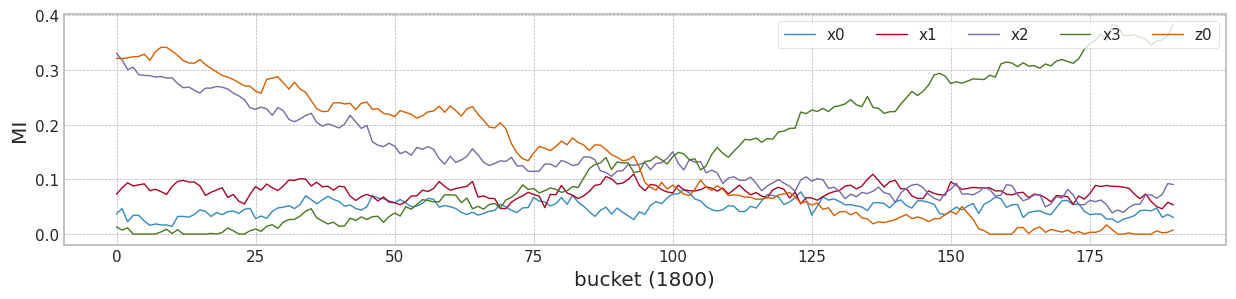

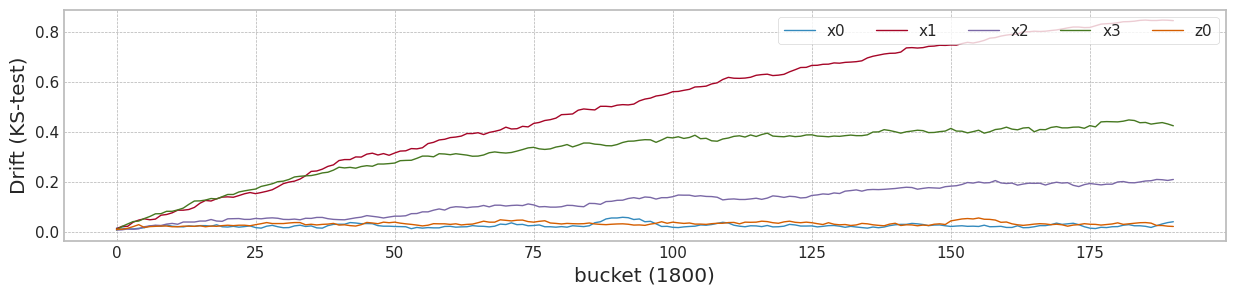

In [157]:
columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)

train_size = 1800
test_size = 200

X1,Y1 = check_mi_drift(X4, y4,train_size, test_size)

In [158]:
X1['b'] = [int(b/100) for b in X1.index.values]
X1

x0        x1        x2        x3        z0    b
0      0.519751  0.387778  0.275001  0.533123  0.339159    0
1      0.605565  0.563470  0.367791  0.564815  0.666164    0
2      0.551222  0.399274  0.575028  0.713089  0.471856    0
3      0.335978  0.536640  0.780598  0.511856  0.609888    0
4      0.496805  0.604664  0.272540  0.446896  0.472373    0
...         ...       ...       ...       ...       ...  ...
39995  0.325122  0.740146  0.182519  0.865448  0.717378  399
39996  0.350268  1.214331  0.189902  0.003441  0.701927  399
39997  0.553850  1.108139  0.668622  2.844378  0.491374  399
39998  0.426469  1.195488  0.410763  1.294958  0.775500  399
39999  0.532744  1.002247  0.002511  3.468541  0.511368  399

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 583.30it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9474662947466295
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.54it/s]


mean of drift:
x0    0.024977
x1    0.502824
x2    0.120791
x3    0.320617
z0    0.032225
dtype: float64
Mean F1 for all data: 0.7787885224109372
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:50<00:00, 79.33it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9592030360531308
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 22.79it/s]


mean of drift:
x0    0.993322
x1    0.827190
x2    0.873604
x3    1.000000
z0    0.631635
dtype: float64
Mean F1 for all data: 0.5625540365226348
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:51<00:00, 78.15it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9377049180327869
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 22.37it/s]


mean of drift:
x0    0.598970
x1    0.457845
x2    0.489846
x3    0.449651
z0    0.861844
dtype: float64
Mean F1 for all data: 0.4054537704796441
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:51<00:00, 78.19it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9488503050211168
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 22.88it/s]


mean of drift:
x0    0.763031
x1    0.280404
x2    0.364229
x3    0.323970
z0    0.840375
dtype: float64
Mean F1 for all data: 0.40296119088242505
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:50<00:00, 79.13it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.948405253283302
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.66it/s]


mean of drift:
x0    0.737708
x1    0.365311
x2    0.354526
x3    0.234668
z0    0.632507
dtype: float64
Mean F1 for all data: 0.5275813048748806
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.43it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.946236559139785
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.09it/s]


mean of drift:
x0    0.703982
x1    0.307435
x2    0.307059
x3    0.250925
z0    0.483333
dtype: float64
Mean F1 for all data: 0.5747178325663065
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.10it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9454036397573494
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.48it/s]


mean of drift:
x0    0.681274
x1    0.238243
x2    0.296178
x3    0.271620
z0    0.423624
dtype: float64
Mean F1 for all data: 0.560934719272467
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:48<00:00, 81.70it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9429234338747099
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.82it/s]


mean of drift:
x0    0.633362
x1    0.144386
x2    0.306280
x3    0.292717
z0    0.348775
dtype: float64
Mean F1 for all data: 0.5659729698018742
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.29it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9407407407407407
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.54it/s]


mean of drift:
x0    0.569729
x1    0.069994
x2    0.285076
x3    0.303642
z0    0.578275
dtype: float64
Mean F1 for all data: 0.4909488223769277
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.45it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.9386248269497001
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.79it/s]


mean of drift:
x0    0.445247
x1    0.186329
x2    0.237984
x3    0.310727
z0    0.480122
dtype: float64
Mean F1 for all data: 0.5460381061648115
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:49<00:00, 81.14it/s]


ty torch.Size([1800])
y_hat (1800, 1)
Test f1 score: 0.938737908797789
X_live.shape (39800, 6)
Truncate 7200 rows from live_set (39800, 6)
Search MI & Drift...for X_live_set torch.Size([191, 1800, 6])


100%|██████████| 191/191 [00:08<00:00, 23.68it/s]


mean of drift:
x0    0.293223
x1    0.334767
x2    0.174229
x3    0.311227
z0    0.224069
dtype: float64
Mean F1 for all data: 0.6394816412728078


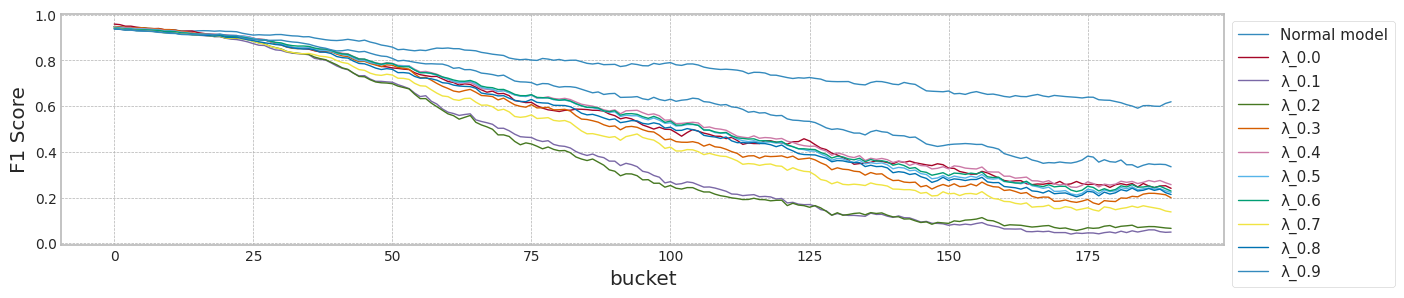

max_mean_lambda= 0.9


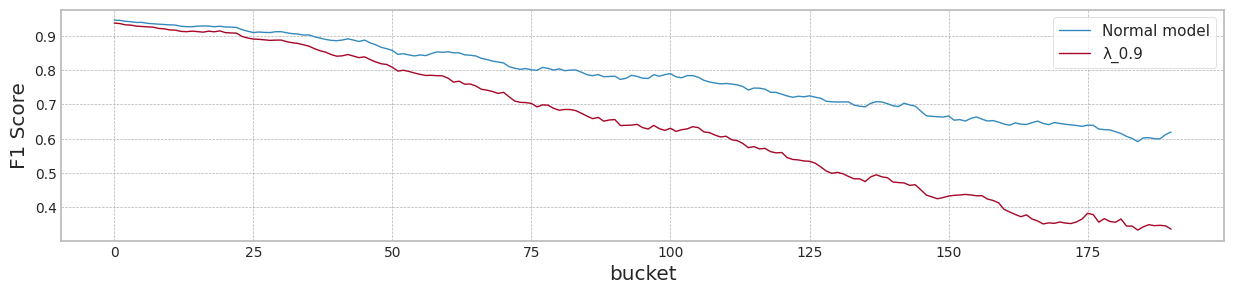

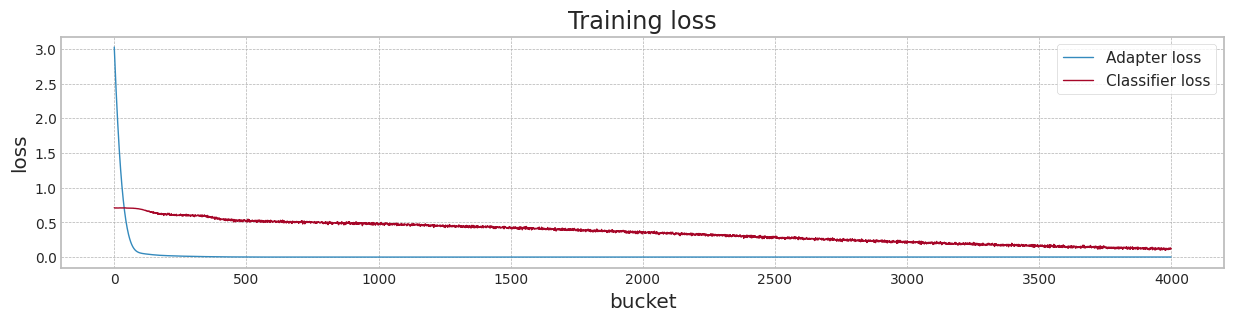

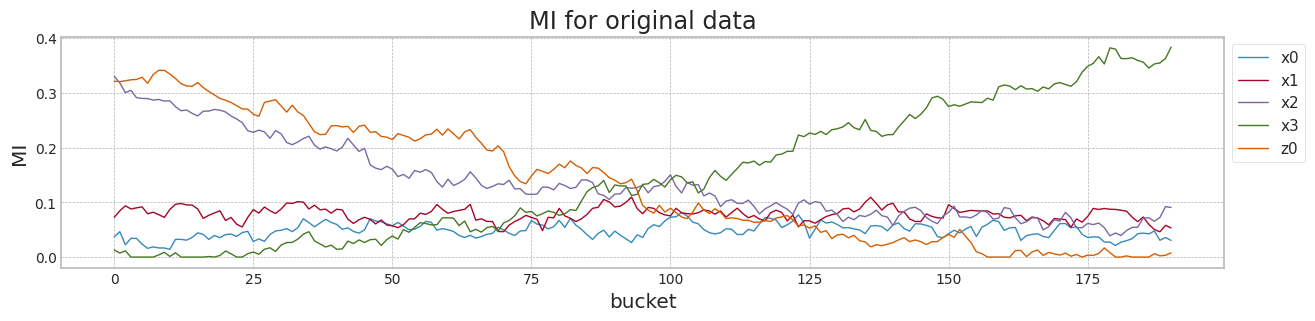

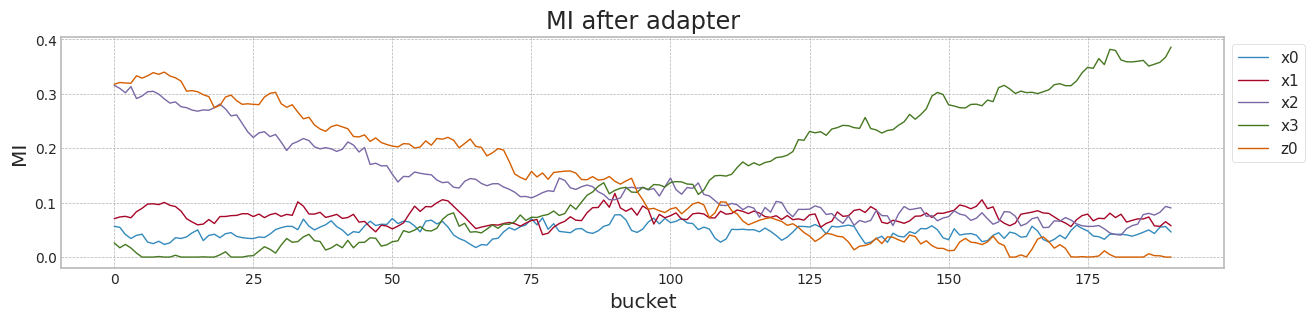

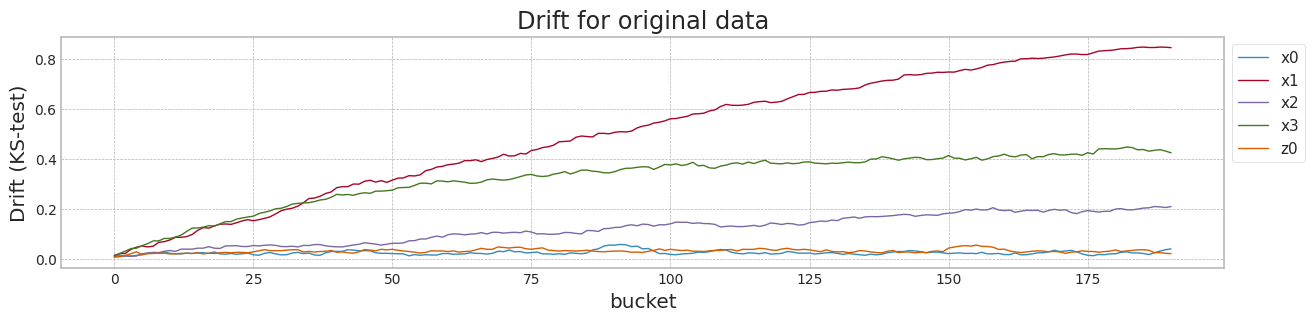

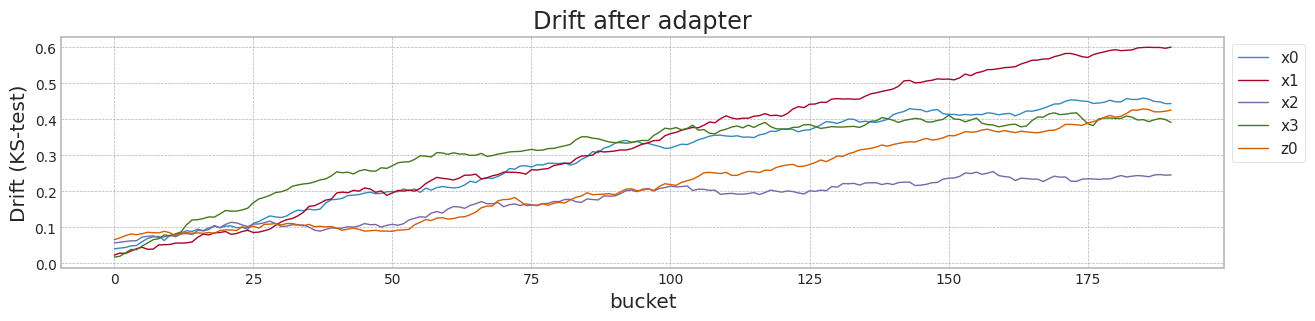

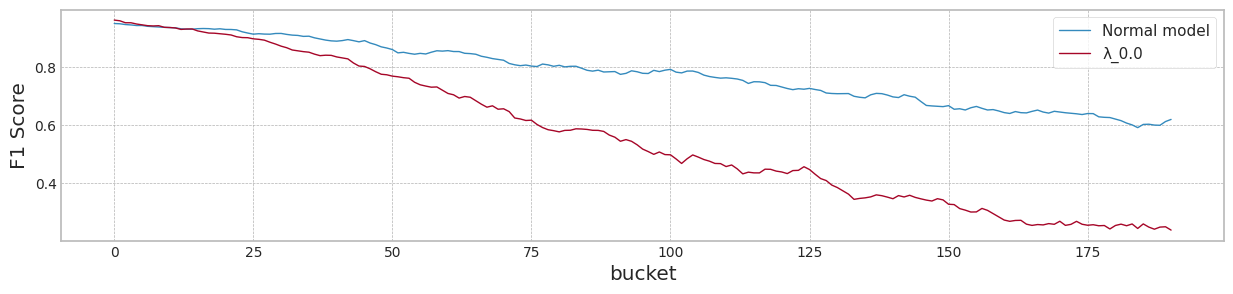

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.947466  0.947466  0.778789  0.619145  0.799602   
1                     0.0  0.959203  0.959203  0.562554  0.240353  0.820026   
2                     0.1  0.937705  0.937705  0.405454  0.048780  0.838075   
3                     0.2  0.948850  0.948850  0.402961  0.065139  0.823966   
4                     0.3  0.948405  0.948405  0.527581  0.198930  0.812424   
5                     0.4  0.946237  0.946237  0.574718  0.256314  0.823193   
6                     0.5  0.945404  0.945404  0.560935  0.222222  0.857875   
7                     0.6  0.942923  0.942923  0.565973  0.228261  0.825283   
8                     0.7  0.940741  0.940741  0.490949  0.136986  0.843385   
9                     0.8  0.938625  0.938625  0.546038  0.213216  0.819689   
10                    0.9  0.938738  0.938738  0.639482  0.334635  0.813653   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.160276   0.128157  0.848758  0.171835  0.785478  0.139901  0.063280   
1   0.146353   0.120013  0.828381  0.165203  0.771437  0.141240  0.056944   
2   0.168501   0.141217  0.837593  0.182102  0.817167  0.161067  0.020426   
3   0.157959   0.130153  0.838758  0.172570  0.813690  0.154860  0.025068   
4   0.162493   0.132013  0.849741  0.166056  0.797881  0.153847  0.051859   
5   0.161707   0.133116  0.859374  0.169743  0.793392  0.156208  0.065982   
6   0.153699   0.131855  0.856700  0.167623  0.788224  0.158703  0.068476   
7   0.159447   0.131589  0.878440  0.164100  0.784581  0.152326  0.093859   
8   0.159759   0.134738  0.840650  0.167096  0.790975  0.148175  0.049675   
9   0.161197   0.132131  0.821004  0.169262  0.797088  0.146819  0.023916   
10  0.149398   0.121558  0.837774  0.169244  0.771203  0.144470  0.066571   

     std 1-2   sum 1+2   std 1+2  
0   0.031935  1.634236  0.311736  
1   0.023963  1.599818  0.306443  
2   0.021035  1.654759  0.343168  
3   0.017710  1.652449  0.327431  
4   0.012209  1.647622  0.319903  
5   0.013535  1.652766  0.325950  
6   0.008920  1.644924  0.326326  
7   0.011774  1.663021  0.316427  
8   0.018921  1.631625  0.315271  
9   0.022443  1.618092  0.316081  
10  0.024774  1.608976  0.313714

In [159]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400)

## real-world data 의 실험

### Loan data 실험

#### Dataset 준비

##### Data load

In [99]:

if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [100]:

df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


##### Data 정제

In [101]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted

(1345310, 151)
(1345310, 101)
(1345310, 56)
(1341026, 56)
(1341026, 53)
(1341026, 44)


id  loan_amnt        term  int_rate grade sub_grade  \
0        68407277     3600.0   36 months     13.99     C        C4   
1        68355089    24700.0   36 months     11.99     C        C1   
2        68341763    20000.0   60 months     10.78     B        B4   
4        68476807    10400.0   60 months     22.45     F        F1   
5        68426831    11950.0   36 months     13.44     C        C3   
...           ...        ...         ...       ...   ...       ...   
2260688  89905081    18000.0   60 months      9.49     B        B2   
2260690  88948836    29400.0   60 months     13.99     C        C3   
2260691  89996426    32000.0   60 months     14.49     C        C4   
2260692  90006534    16000.0   60 months     12.79     C        C1   
2260697  88224441    24000.0   60 months     14.49     C        C4   

        home_ownership  annual_inc verification_status   issue_d  ...  \
0             MORTGAGE     55000.0        Not Verified  Dec-2015  ...   
1             MORTGAGE     65000.0        Not Verified  Dec-2015  ...   
2             MORTGAGE     63000.0        Not Verified  Dec-2015  ...   
4             MORTGAGE    104433.0     Source Verified  Dec-2015  ...   
5                 RENT     34000.0     Source Verified  Dec-2015  ...   
...                ...         ...                 ...       ...  ...   
2260688            OWN    130000.0        Not Verified  Oct-2016  ...   
2260690       MORTGAGE    180792.0        Not Verified  Oct-2016  ...   
2260691       MORTGAGE    157000.0     Source Verified  Oct-2016  ...   
2260692           RENT    150000.0        Not Verified  Oct-2016  ...   
2260697           RENT    110000.0        Not Verified  Oct-2016  ...   

        application_type acc_now_delinq chargeoff_within_12_mths delinq_amnt  \
0             Individual            0.0                      0.0         0.0   
1             Individual            0.0                      0.0         0.0   
2              Joint App            0.0                      0.0         0.0   
4             Individual            0.0                      0.0         0.0   
5             Individual            0.0                      0.0         0.0   
...                  ...            ...                      ...         ...   
2260688       Individual            0.0                      0.0         0.0   
2260690       Individual            0.0                      0.0         0.0   
2260691       Individual            0.0                      0.0         0.0   
2260692       Individual            0.0                      0.0         0.0   
2260697       Individual            0.0                      0.0         0.0   

        pub_rec_bankruptcies  tax_liens  hardship_flag disbursement_method  \
0                        0.0        0.0              N                Cash   
1                        0.0        0.0              N                Cash   
2                        0.0        0.0              N                Cash   
4                        0.0        0.0              N                Cash   
5                        0.0        0.0              N                Cash   
...                      ...        ...            ...                 ...   
2260688                  0.0        0.0              N                Cash   
2260690                  0.0        0.0              N                Cash   
2260691                  0.0        0.0              N                Cash   
2260692                  3.0        0.0              N                Cash   
2260697                  1.0        0.0              N                Cash   

         debt_settlement_flag  loan_paid  
0                           N          1  
1                           N          1  
2                           N          1  
4                           N          1  
5                           N          1  
...                       ...        ...  
2260688                     N          1  
2260690                     N          1  
2260691     

In [102]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
(1341026, 41)
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
(1341026, 86)
(1341026, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  

##### Dataset 만들기

In [103]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [104]:

X[2010].shape

(11497, 81)

In [105]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

In [106]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

recoveries              0.375194
last_fico_range_high    0.092181
last_pymnt_amnt         0.085660
total_rec_late_fee      0.028345
int_rate                0.017441
                          ...   
revol_bal               0.000000
E5                      0.000000
F5                      0.000000
C2                      0.000000
total_acc               0.000000
Name: MI Scores, Length: 81, dtype: float64


In [107]:
# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate']

+ 일부러 예측 확률을 떨어뜨리기 위해 (조정), "recoveries" feature를 제외 한다.

In [108]:
top_columns = list(mi_scores[1:10].index)
top_columns

['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate',
 'term',
 'Y',
 'total_rec_int',
 'RENT',
 'G4']

In [109]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 2, 1, 80, 13, 78, 56]

In [110]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]
#X2_df_t5 = X2_df[top_columns]

#### 실험

MI Analysis MI Max 0.31588, Min 0.00109, Mean 0.10149, Std 0.10695
Dataset structure X_train, (10000, 9) X_test, (10000, 9) X_live (1278183, 9)
Truncate 28665 rows from live_set (1278183, 9)
Search MI & Drift...for X_live_set (848, 10000, 9)


100%|██████████| 848/848 [05:09<00:00,  2.74it/s]


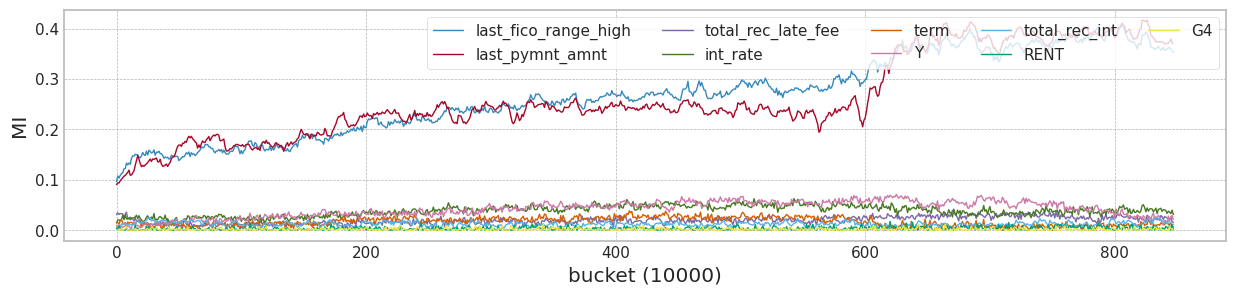

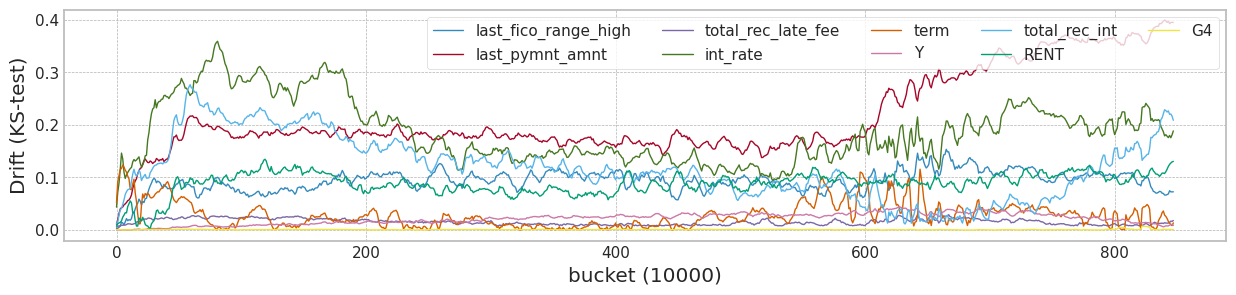

In [111]:
train_size = 10000
test_size = 1497

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)

In [112]:
X1['b'] = [int(b/1000) for b in X1.index.values]
X1

last_fico_range_high  last_pymnt_amnt  total_rec_late_fee  int_rate  \
0                    0.928910         0.032896            0.000000  0.502466   
1                    0.863744         0.010440            0.000000  0.416769   
2                    0.727488         0.381296            0.000000  0.566584   
3                    0.869668         0.021731            0.000000  0.652281   
4                    0.952607         0.027513            0.000000  0.395191   
...                       ...              ...                 ...       ...   
1279675              0.917062         0.000269            0.090128  0.278052   
1279676              0.857820         0.403841            0.000000  0.278052   
1279677              0.905213         0.334665            0.000000  0.157213   
1279678              0.922986         0.971979            0.000000 -0.006165   
1279679              0.881517         0.377212            0.000000  1.564118   

         term    Y  total_rec_int  RENT   G4     b  
0         0.0  0.0       0.175629   1.0  0.0     0  
1         0.0  0.0       0.097918   1.0  0.0     0  
2         0.0  0.0       0.023318   0.0  0.0     0  
3         0.0  0.0       0.262327   1.0  0.0     0  
4         0.0  0.0       0.253892   0.0  0.0     0  
...       ...  ...            ...   ...  ...   ...  
1279675   0.0  0.0       0.031754   1.0  0.0  1279  
1279676   0.0  0.0       0.099365   0.0  0.0  1279  
1279677   0.0  0.0       0.026058   1.0  0.0  1279  
1279678   0.0  0.0       0.085987   0.0  0.0  1279  
1279679   1.0  0.0       0.186533   1.0  0.0  1279  

[1279680 rows x 10 columns]

In [128]:
a = np.asarray([1,2,3,4,5,6])
a[:-1]

array([1, 2, 3, 4, 5])

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:07<00:00, 554.20it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9396193393130605
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:02<00:00,  2.80it/s]


mean of drift:
last_fico_range_high    0.117682
last_pymnt_amnt         0.214501
total_rec_late_fee      0.019389
int_rate                0.187503
term                    0.028391
Y                       0.021749
total_rec_int           0.117911
RENT                    0.088541
G4                      0.000962
dtype: float64
Mean F1 for all data: 0.9215728586541053
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [01:19<00:00, 50.57it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9472086355203239
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [04:55<00:00,  2.87it/s]


mean of drift:
last_fico_range_high    0.998958
last_pymnt_amnt         0.995984
total_rec_late_fee      0.999968
int_rate                1.000000
term                    0.827837
Y                       1.000000
total_rec_int           1.000000
RENT                    1.000000
G4                      1.000000
dtype: float64
Mean F1 for all data: 0.9047429472932462
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [01:19<00:00, 50.57it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9466168349417081
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [04:55<00:00,  2.87it/s]


mean of drift:
last_fico_range_high    0.924993
last_pymnt_amnt         0.936455
total_rec_late_fee      0.992863
int_rate                0.847284
term                    0.868028
Y                       0.972289
total_rec_int           0.960931
RENT                    0.600917
G4                      0.997073
dtype: float64
Mean F1 for all data: 0.8886243355571112
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [01:20<00:00, 49.67it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9455252918287937
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [04:55<00:00,  2.87it/s]


mean of drift:
last_fico_range_high    0.905716
last_pymnt_amnt         0.525266
total_rec_late_fee      0.991838
int_rate                0.815597
term                    0.761196
Y                       0.978428
total_rec_int           0.956229
RENT                    0.601600
G4                      0.998400
dtype: float64
Mean F1 for all data: 0.8891612148658131
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [01:20<00:00, 49.66it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9444074567243675
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [04:56<00:00,  2.86it/s]


mean of drift:
last_fico_range_high    0.903395
last_pymnt_amnt         0.484388
total_rec_late_fee      0.991892
int_rate                0.846310
term                    0.757953
Y                       0.981178
total_rec_int           0.944731
RENT                    0.601214
G4                      0.998400
dtype: float64
Mean F1 for all data: 0.8893762942511887
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [01:22<00:00, 48.51it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9438848920863309
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [04:56<00:00,  2.86it/s]


mean of drift:
last_fico_range_high    0.816040
last_pymnt_amnt         0.604519
total_rec_late_fee      0.991231
int_rate                0.780541
term                    0.757719
Y                       0.977782
total_rec_int           0.936991
RENT                    0.601332
G4                      0.998400
dtype: float64
Mean F1 for all data: 0.89031210791449
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [01:21<00:00, 49.19it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9433670368528649
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [04:59<00:00,  2.83it/s]


mean of drift:
last_fico_range_high    0.775703
last_pymnt_amnt         0.463719
total_rec_late_fee      0.988991
int_rate                0.641301
term                    0.757719
Y                       0.972311
total_rec_int           0.928689
RENT                    0.601456
G4                      0.998400
dtype: float64
Mean F1 for all data: 0.8929994214933983
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [01:20<00:00, 49.58it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9426695359487943
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [04:54<00:00,  2.88it/s]


mean of drift:
last_fico_range_high    0.725609
last_pymnt_amnt         0.457094
total_rec_late_fee      0.987761
int_rate                0.565138
term                    0.758254
Y                       0.972312
total_rec_int           0.913883
RENT                    0.601608
G4                      0.997691
dtype: float64
Mean F1 for all data: 0.844196834176669
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [01:20<00:00, 49.91it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.942452778236687
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [04:54<00:00,  2.88it/s]


mean of drift:
last_fico_range_high    0.544985
last_pymnt_amnt         0.464272
total_rec_late_fee      0.987247
int_rate                0.387519
term                    0.758503
Y                       0.972257
total_rec_int           0.884459
RENT                    0.601720
G4                      0.996690
dtype: float64
Mean F1 for all data: 0.7236849729424437
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [01:19<00:00, 50.45it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.9416808662672457
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [04:54<00:00,  2.88it/s]


mean of drift:
last_fico_range_high    0.602605
last_pymnt_amnt         0.464400
total_rec_late_fee      0.981883
int_rate                0.253934
term                    0.758254
Y                       0.972314
total_rec_int           0.838229
RENT                    0.601747
G4                      0.996985
dtype: float64
Mean F1 for all data: 0.8935908733309155
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [01:19<00:00, 50.24it/s]


ty torch.Size([10000])
y_hat (10000, 1)
Test f1 score: 0.939900290363228
X_live.shape (1278183, 10)
Truncate 28665 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [04:55<00:00,  2.87it/s]


mean of drift:
last_fico_range_high    0.121170
last_pymnt_amnt         0.468790
total_rec_late_fee      0.988864
int_rate                0.171421
term                    0.758065
Y                       0.972310
total_rec_int           0.749765
RENT                    0.601741
G4                      0.996690
dtype: float64
Mean F1 for all data: 0.9222870171368669


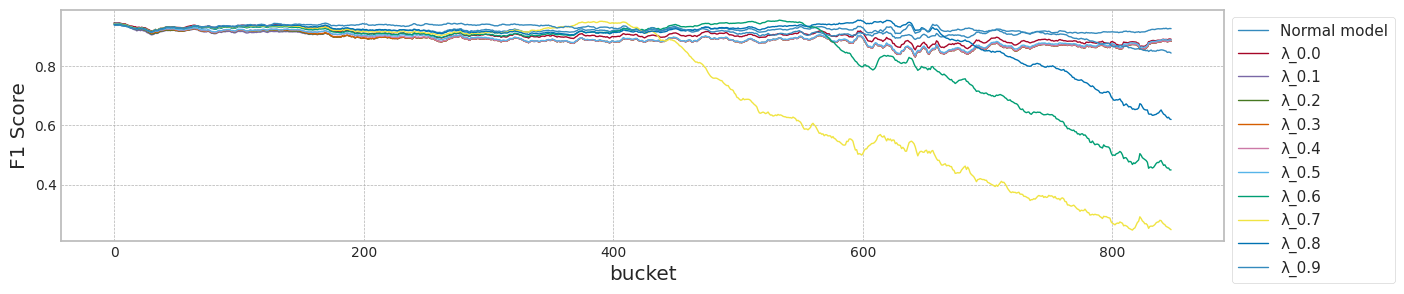

max_mean_lambda= 0.9


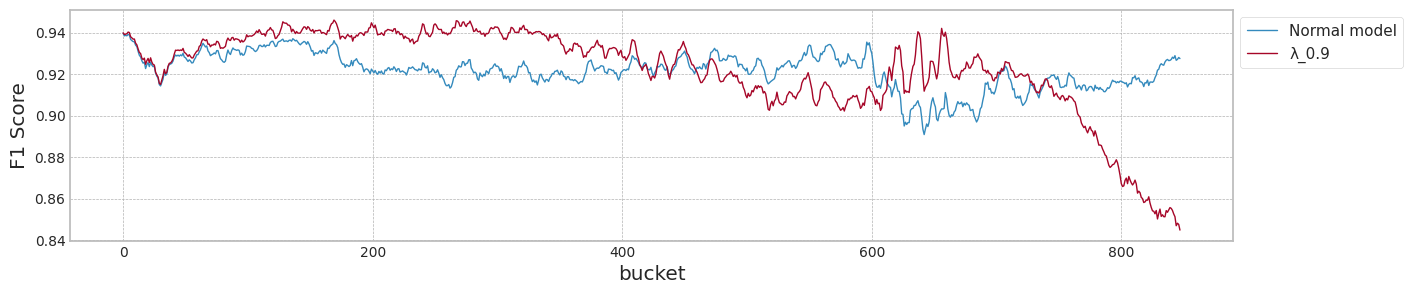

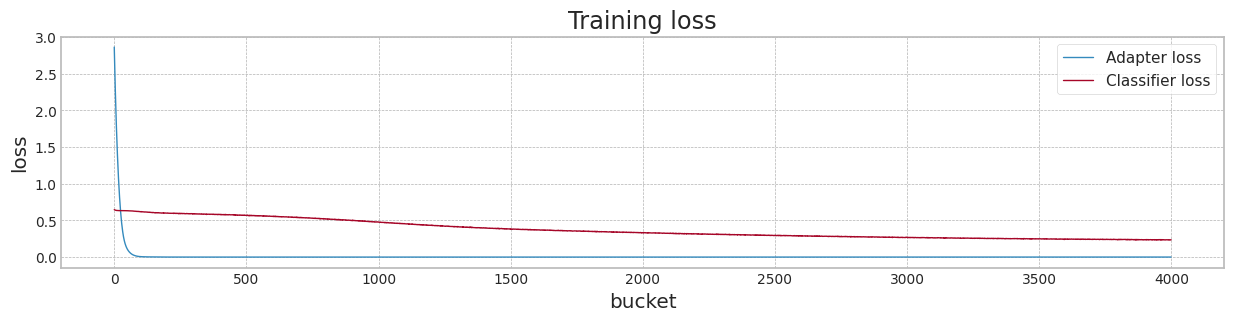

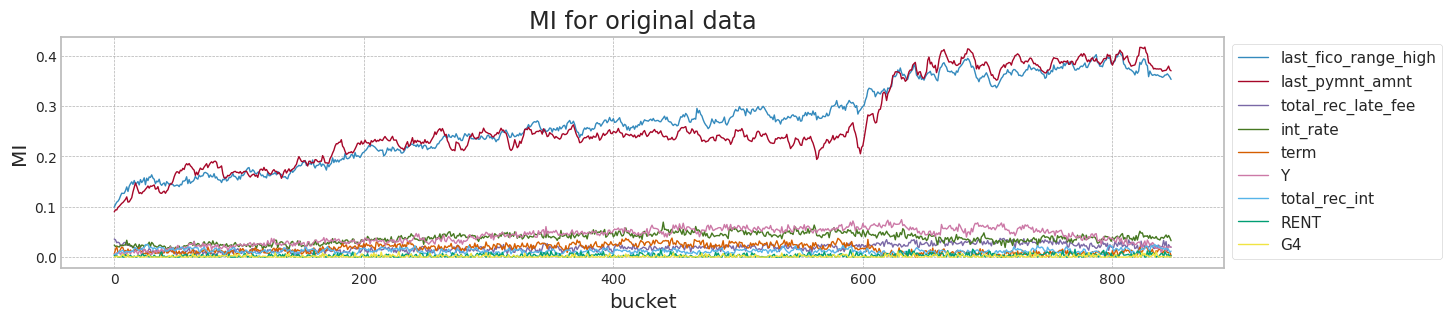

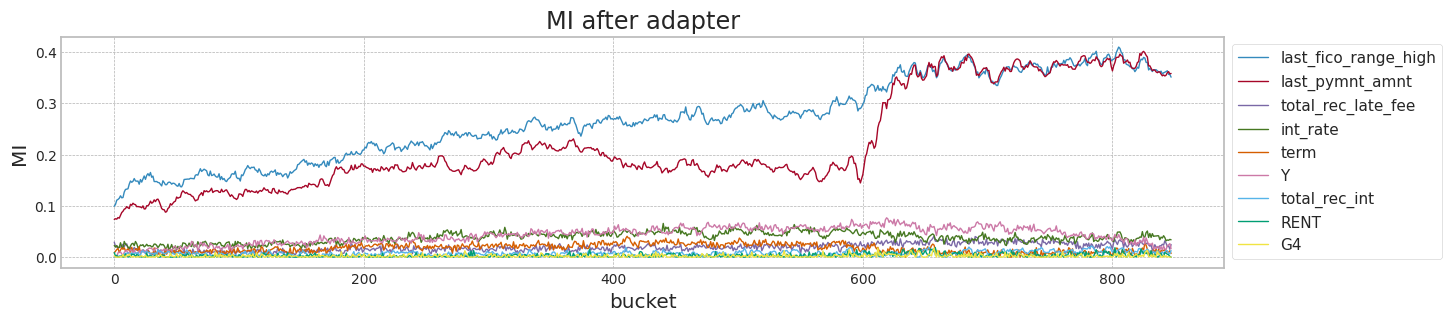

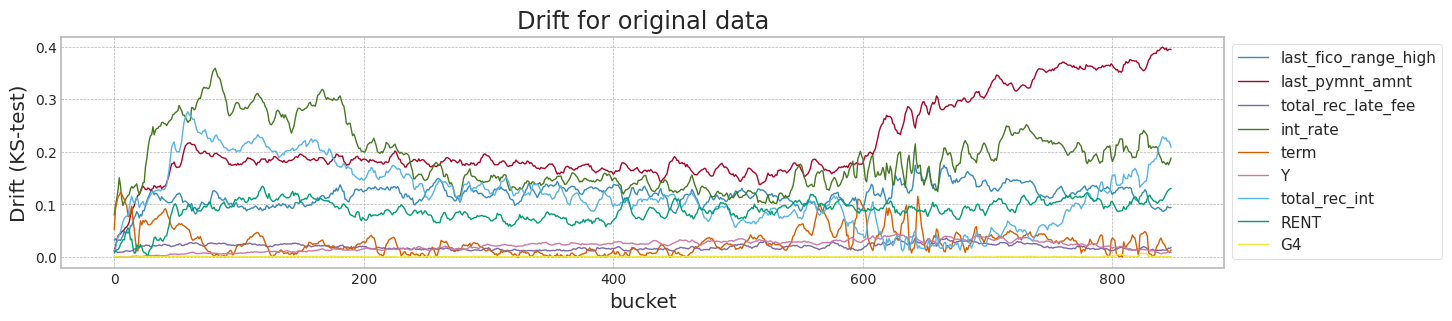

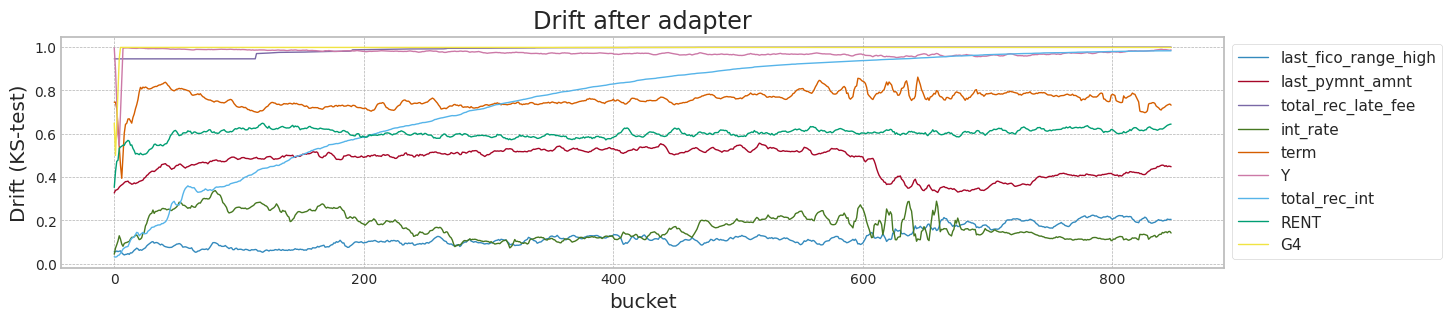

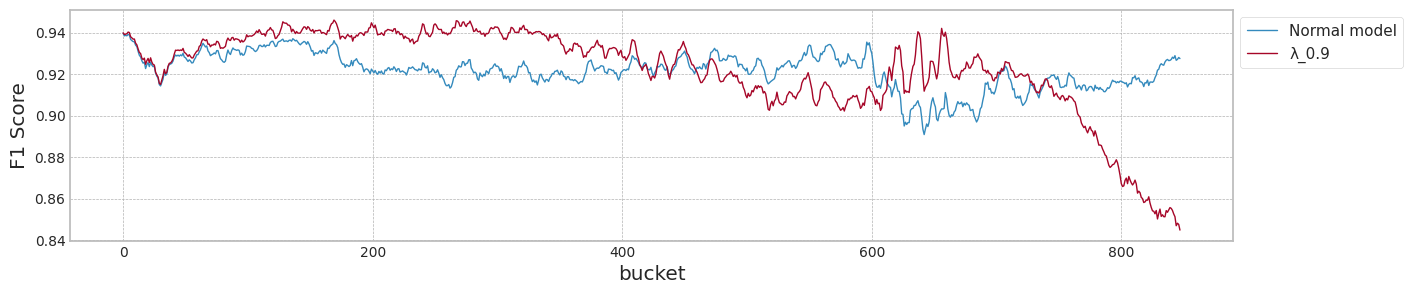

lambda   test_f1   init_f1   mean_f1   last_f1    sum mi  \
0   Case #1, Normal model  0.939619  0.939619  0.921573  0.927481  0.154795   
1                     0.0  0.947209  0.947209  0.904743  0.891474  0.304811   
2                     0.1  0.946617  0.946617  0.888624  0.884675  0.289133   
3                     0.2  0.945525  0.945525  0.889161  0.884675  0.269832   
4                     0.3  0.944407  0.944407  0.889376  0.884725  0.264907   
5                     0.4  0.943885  0.943885  0.890312  0.885328  0.256024   
6                     0.5  0.943367  0.943367  0.892999  0.889051  0.249480   
7                     0.6  0.942670  0.942670  0.844197  0.449418  0.243065   
8                     0.7  0.942453  0.942453  0.723685  0.247265  0.237402   
9                     0.8  0.941681  0.941681  0.893591  0.619988  0.216225   
10                    0.9  0.939900  0.939900  0.922287  0.844810  0.188418   

      std mi  sum * std   sum 1/2   std 1/2   sum 2/2   std 2/2   sum 1-2  \
0   0.015148   0.002345  0.161720  0.014721  0.161894  0.014506  0.000174   
1   0.035917   0.010948  0.284487  0.033888  0.325228  0.039714  0.040741   
2   0.034767   0.010052  0.281707  0.036711  0.283611  0.035323  0.001904   
3   0.030862   0.008327  0.262702  0.032504  0.270129  0.032139  0.007427   
4   0.029056   0.007697  0.253072  0.030370  0.263436  0.030802  0.010365   
5   0.026001   0.006657  0.243582  0.026741  0.243990  0.027818  0.000408   
6   0.024782   0.006183  0.230137  0.025331  0.238468  0.026802  0.008331   
7   0.023037   0.005599  0.233724  0.024098  0.233111  0.024065  0.000613   
8   0.020898   0.004961  0.223327  0.022668  0.223597  0.022412  0.000270   
9   0.020085   0.004343  0.216162  0.020948  0.205785  0.020447  0.010378   
10  0.017348   0.003269  0.180157  0.017651  0.188727  0.017002  0.008571   

     std 1-2   sum 1+2   std 1+2  
0   0.000214  0.323614  0.029227  
1   0.005826  0.609715  0.073602  
2   0.001388  0.565318  0.072035  
3   0.000365  0.532831  0.064643  
4   0.000432  0.516508  0.061171  
5   0.001076  0.487573  0.054559  
6   0.001471  0.468605  0.052133  
7   0.000033  0.466835  0.048163  
8   0.000256  0.446924  0.045080  
9   0.000501  0.421947  0.041395  
10  0.000648  0.368884  0.034653

In [130]:
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = np.max(X1['b']))

### Card data 실험

#### Dataset 준비

In [17]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [18]:
!kaggle datasets download "ealtman2019/credit-card-transactions"

 95% 249M/263M [00:02<00:00, 105MB/s]
100% 263M/263M [00:02<00:00, 112MB/s]


In [19]:
!unzip credit-card-transactions.zip

Archive:  credit-card-transactions.zip
  inflating: User0_credit_card_transactions.csv  
  inflating: credit_card_transactions-ibm_v2.csv  
  inflating: sd254_cards.csv         
  inflating: sd254_users.csv         


In [98]:
df = pd.read_csv("credit_card_transactions-ibm_v2.csv")

In [39]:
df['Year'].value_counts()

2019    1723938
2017    1723360
2018    1721615
2016    1708924
2015    1701371
2014    1672343
2013    1650917
2012    1610829
2011    1570551
2010    1491225
2009    1355434
2008    1223460
2007    1064483
2006     908793
2005     746653
2004     597003
2003     466408
2002     350732
2020     336500
2001     257998
2000     177729
1999     118250
1998      78345
1997      49753
1996      29945
1995      20928
1994      14316
1993       8378
1992       5134
1991       1585
Name: Year, dtype: int64

In [40]:
import lightgbm as lgb
from sklearn.metrics import classification_report
df['Is Fraud?']=df['Is Fraud?'].replace({'No':0,'Yes':1})
df1 = df[df['Is Fraud?']==1]
df2 = df[df['Is Fraud?']==0]
df3 = df2.sample(int(df2.shape[0]/30))
df4 = pd.concat([df1,df3])

print("Compression rate:",df4.shape[0] / df.shape[0] )

df = df4

Compression rate: 0.034512832709364456


In [41]:
df['Errors?']=df['Errors?'].fillna('NAN')
df['Errors?']=df['Errors?'].apply(lambda value:value=='NAN')
df['Errors?'].value_counts()

df['Use Chip'].unique()
df['is online']=df['Use Chip'].apply(lambda value:value=='Online Transaction')

from sklearn.preprocessing import LabelEncoder
df['Use Chip']=df['Use Chip'].replace({'Swipe Transaction':0, 'Online Transaction':1, 'Chip Transaction':2})
df['Zip'] = df['Zip'].fillna(df['Zip'].mean())
df['Amount'] = df['Amount'].apply(lambda value: float(value.split("$")[1]))
df['Hour'] = df['Time'].apply(lambda value: int(value.split(":")[0]))
df['Minutes'] = df['Time'].apply(lambda value: int(value.split(":")[1]))
df.drop(['Time'], axis=1, inplace=True)
df['Merchant State']=df['Merchant State'].fillna('NAN')
df['Merchant City']=df['Merchant City'].fillna('NAN')
df['is vozmes']=df['Amount'].apply(lambda value: value<0)
df['abs_amount']=df['Amount'].apply(lambda value: abs(value))

#encoding categorial features
le=LabelEncoder()
df['Merchant State']=le.fit_transform(df['Merchant State'])
le=LabelEncoder()
df['Merchant City']=le.fit_transform(df['Merchant City'])
le=LabelEncoder()
df['Errors?']=le.fit_transform(df['Errors?'])
le=LabelEncoder()
df['is online']=le.fit_transform(df['is online'])
le=LabelEncoder()
df['is vozmes']=le.fit_transform(df['is vozmes'])

df = df.sort_values(['Year','Month','Day'])

df.Year.value_counts()

2016    60412
2015    60116
2018    59563
2019    59488
2017    57276
2013    57029
2014    56782
2012    54838
2010    53127
2011    52594
2009    46612
2008    44566
2007    37404
2006    31560
2005    25216
2004    20436
2003    15753
2002    11773
2020    11251
2001     8820
2000     6049
1999     3969
1998     2689
1997     1641
1996      968
1995      691
1994      511
1993      276
1992      185
1991       66
Name: Year, dtype: int64

In [42]:
drop_columns = ['Is Fraud?','Zip','Year','Month','Day','Minutes','User','Errors?','Merchant Name','Merchant City','Merchant State']
X = df[(df['Year']==2005) |(df['Year']==2006) | (df['Year']==2007) | (df['Year']==2008) | (df['Year']==2009)].drop(drop_columns,axis=1)
y = df[(df['Year']==2005) |(df['Year']==2006) | (df['Year']==2007) | (df['Year']==2008) | (df['Year']==2009)]['Is Fraud?']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185358 entries, 17325692 to 342823
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Card        185358 non-null  int64  
 1   Amount      185358 non-null  float64
 2   Use Chip    185358 non-null  int64  
 3   MCC         185358 non-null  int64  
 4   is online   185358 non-null  int64  
 5   Hour        185358 non-null  int64  
 6   is vozmes   185358 non-null  int64  
 7   abs_amount  185358 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 12.7 MB


In [48]:
np.sum(y[0:30000])

536

#### 실험

MI Analysis MI Max 0.04861, Min 0.00078, Mean 0.01996, Std 0.01460
Dataset structure X_train, (30000, 8) X_test, (30000, 8) X_live (182358, 8)
Truncate 156222 rows from live_set (182358, 8)
Search MI & Drift...for X_live_set (51, 30000, 8)


100%|██████████| 51/51 [00:54<00:00,  1.06s/it]


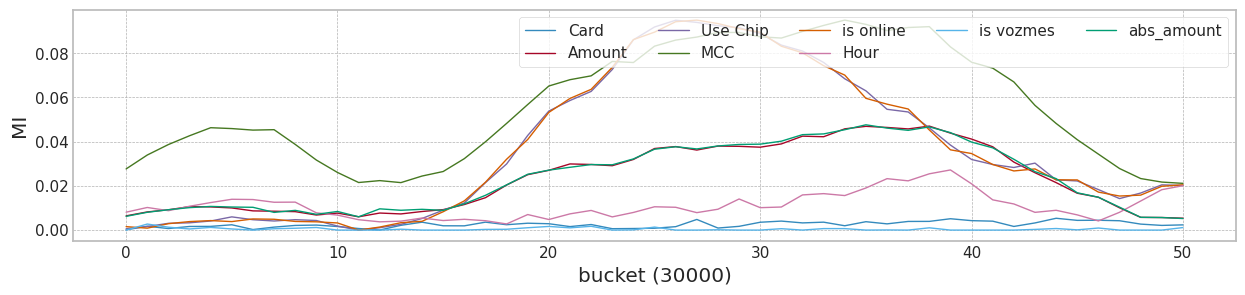

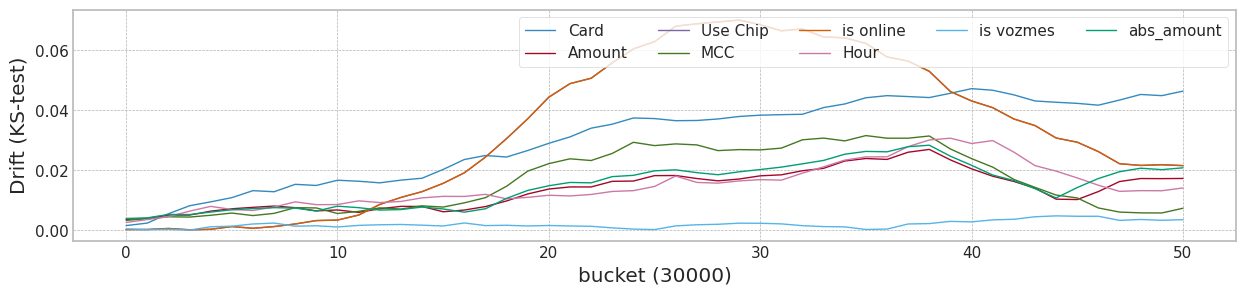

In [49]:

train_size = 30000
test_size = 3000

X1,Y1 = check_mi_drift(X, y.values,train_size, test_size)

MI Analysis MI Max 0.02838, Min 0.00038, Mean 0.00683, Std 0.00866
cuda:0


100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]

MSE: 0.10
RMSE: 0.32


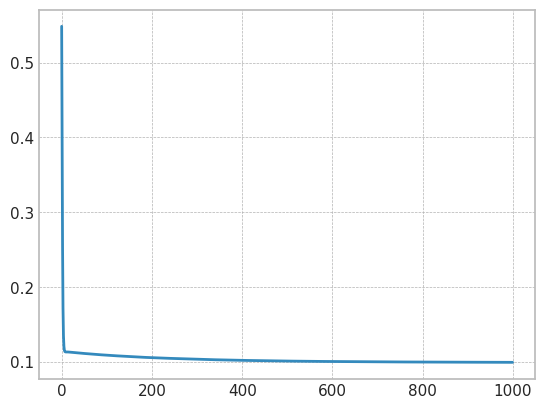

F1 Score:0.00000
Dataset structure X_train, torch.Size([30000, 8]) X_test, torch.Size([30000, 8]) X_live (182358, 8)
Truncate 156222 rows from live_set (182358, 8)


100%|██████████| 51/51 [00:00<00:00, 96.38it/s]


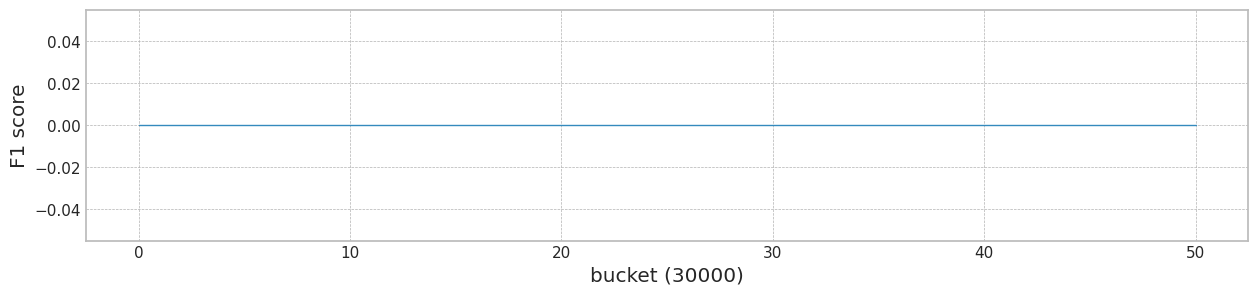

   test_f1  init_f1  mean_f1  last_f1   SUM(MI)
0      0.0      0.0      0.0      0.0  0.054619


In [50]:
model,df = train_classificaion_model(X1,Y1,train_size, test_size)